In this tutorial, we will run a quicklook spectrotemporal analysis of a NICER observation of one epoch of the 2018 outburst of the accreting black hole MAXI 1820+070, largely reproducing the results from, e.g., [Wang et al. 2021](https://ui.adsabs.harvard.edu/abs/2021ApJ...910L...3W/abstract), [De Marco et al. 2021](https://ui.adsabs.harvard.edu/abs/2021A%26A...654A..14D/abstract). We will not give a scientific interpretation, just pure exploration.

We will use the [Stingray](https://docs.stingray.science) software package, at the version specified in the installation process.

Let us first install the correct software version. From the shell,

```
$ pip install stingray pyfftw
```

The source code is available in the [official Github repository](https://github.com/stingraysoftware/stingray)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import glob
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.modeling import models

from stingray.gti import create_gti_from_condition, gti_border_bins, time_intervals_from_gtis, cross_two_gtis
from stingray.utils import show_progress
from stingray.fourier import avg_cs_from_events, avg_pds_from_events, poisson_level, get_average_ctrate
from stingray import AveragedPowerspectrum, AveragedCrossspectrum, EventList
from stingray.modeling.parameterestimation import PSDLogLikelihood

params = {
    'font.size': 7,
    'xtick.major.size': 0,
    'xtick.minor.size': 0,
    'xtick.major.width': 0,
    'xtick.minor.width': 0,
    'ytick.major.size': 0,
    'ytick.minor.size': 0,
    'ytick.major.width': 0,
    'ytick.minor.width': 0,
    'figure.figsize': (6, 4),
    "axes.grid" : True,
    "grid.color": "grey",
    "grid.linewidth": 0.3,
    "grid.linestyle": ":",
    "axes.grid.axis": "y",
    "axes.grid.which": "both",
    "axes.axisbelow": False,
    'axes.labelsize': 8,
    'xtick.labelsize': 8,
    'ytick.labelsize': 8,
    'legend.fontsize': 8,
    'legend.title_fontsize': 8,
    'figure.dpi': 300,  # the left side of the subplots of the figure
    'figure.subplot.left': 0.195,  # the left side of the subplots of the figure
    'figure.subplot.right': 0.97,   # the right side of the subplots of the figure
    'figure.subplot.bottom': 0.145,   # the bottom of the subplots of the figure
    'figure.subplot.top': 0.97,   # the top of the subplots of the figure
    'figure.subplot.wspace': 0.2,    # the amount of width reserved for space between subplots,
                                   # expressed as a fraction of the average axis width
    'figure.subplot.hspace': 0.2,    # the amount of height reserved for space between subplots,
                               # expressed as a fraction of the average axis height
}
mpl.rcParams.update(params)

## Load events and plot light curve

Let us take a look at the light curve. We load the NICER event list into a `stingray.EventList` object, and create a `stingray.Lightcurve` from it.

In [2]:
fname = "ni1200120106_0mpu7_cl_bary.evt.gz"
events = EventList.read(fname, "hea")
events.fname = fname



Text(0, 0.5, 'Counts/bin')

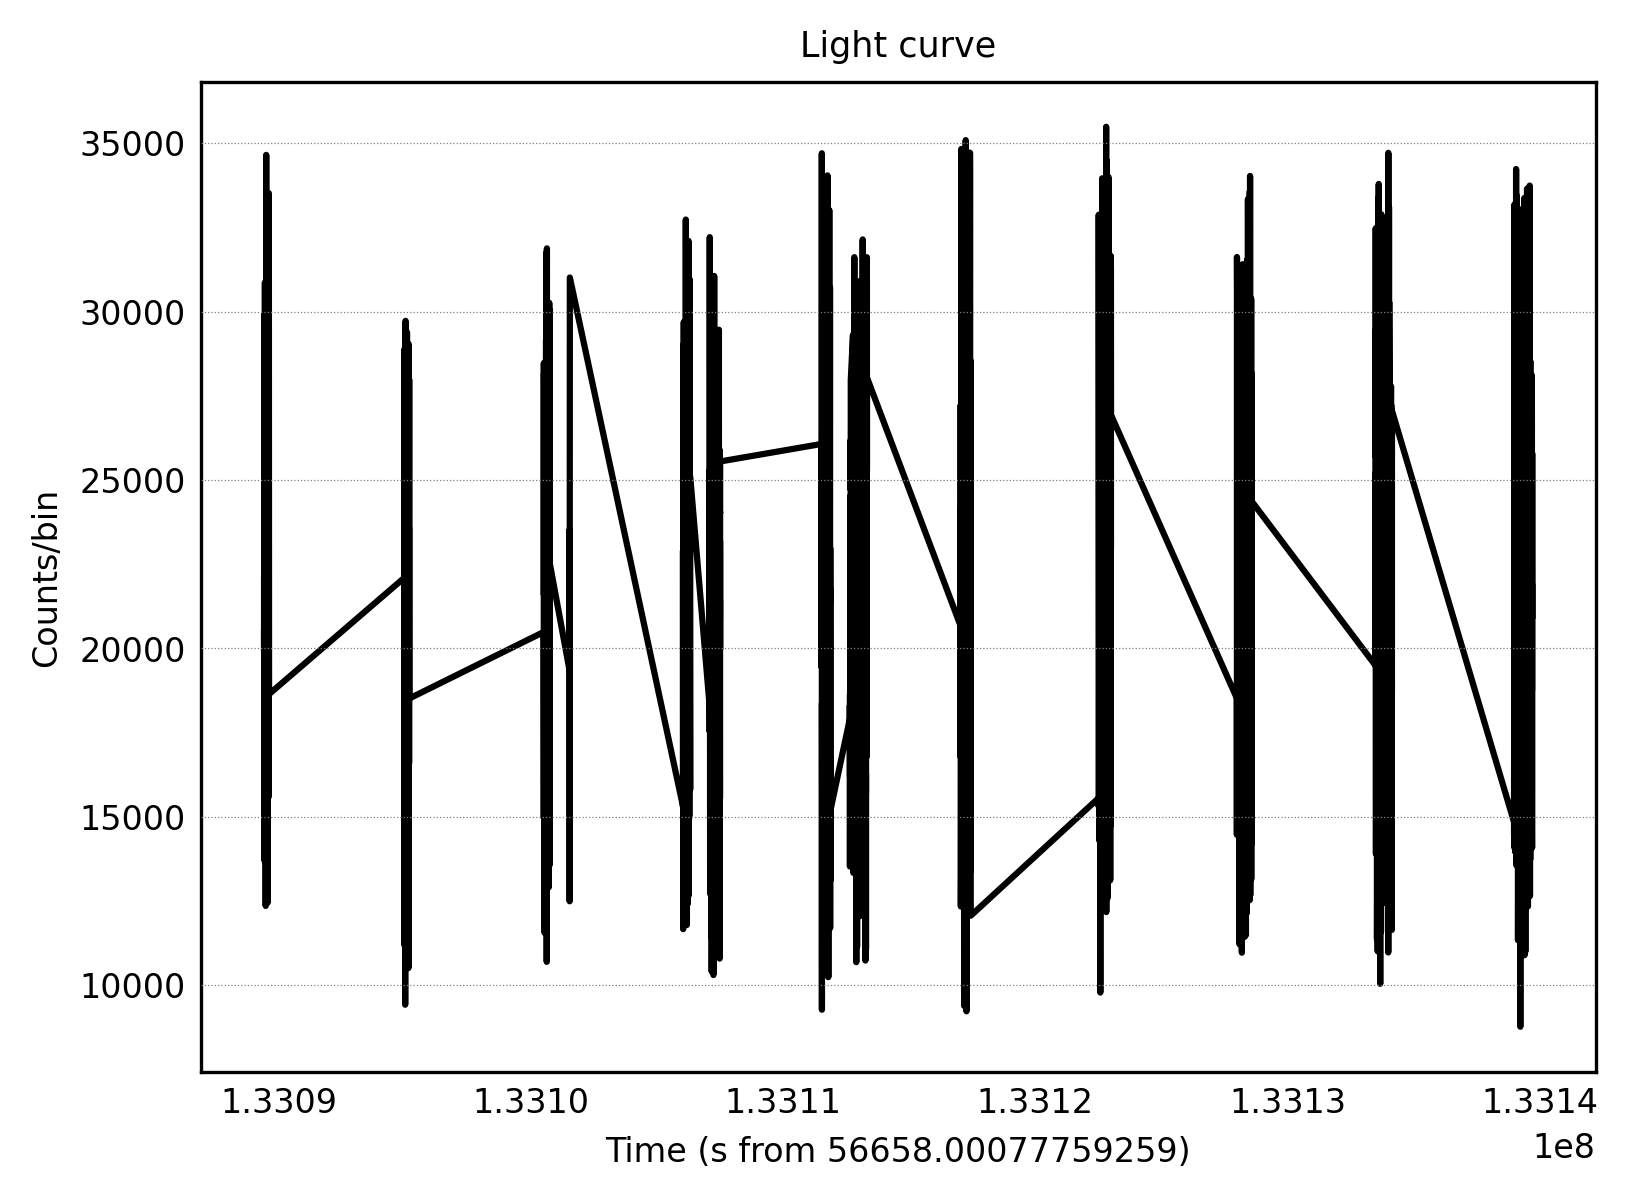

In [3]:
# Create light curve and apply GTIs
lc_raw = events.to_lc(dt=1)
lc_raw.apply_gtis()

plt.figure()
plt.plot(lc_raw.time, lc_raw.counts, color="k")
plt.title("Light curve")
plt.xlabel(f"Time (s from {events.mjdref})")
plt.ylabel(f"Counts/bin")


The light curve seems reasonably clean, with no need for further cleaning. Otherwise, we would have to filter out, e.g. flares or intervals with zero counts, doing something along the lines of:

```
new_gti = create_gti_from_condition(lc_raw.time, lc_raw.counts > 0, safe_interval=1)
lc = copy.deepcopy(lc_raw)
lc.gti = new_gti
lc.apply_gtis()

plt.figure()
plt.plot(lc_raw.time, lc_raw.counts, color="grey", alpha=0.5, label="Raw")
plt.plot(lc.time, lc.counts, color="k", label="Cleaned")
plt.title("Light curve")
plt.xlabel(f"Time (s from {events.mjdref})")
plt.ylabel(f"Counts/bin")
plt.legend();

events.gti = new_gti
```

## Calculate periodogram and cross spectrum

Let us now take a look at the periodogram and the cross spectrum. 
The periodogram will be obtained with Bartlett's method: splitting the light curve into equal-length segments, calculating the periodogram in each, and then averaging them into the final periodogram.

We will use the fractional rms normalization (sometimes referred to as the _Belloni_, or _Miyamoto_, normalization, from the papers [Belloni & Hasinger 1990](https://ui.adsabs.harvard.edu/abs/1990A%26A...230..103B/abstract), [Miyamoto et al. 1992](https://ui.adsabs.harvard.edu/abs/1992ApJ...391L..21M/abstract)). The background contribution is negligible and will be ignored.

Note: since the fractional rms normalization uses the mean count rate, the final result changes slightly if the normalization is applied in the single periodograms from each light curve segment, with the count rate of each chunk, or on the averaged periodogram, using the average count rate of the full light curve. We choose the second option (note the `use_common_mean=True`).

We will first plot the periodogram as is, in units of $(\mathrm{rms/mean)^2\,Hz^{-1}}$.

Then, from the periodogram, we will subtract the theoretical Poisson noise level of $2/\mu$, where $\mu$ is the mean count rate in the observation, and we will multiply the powers by the frequency, to have the periodogram in units of $(\mathrm{rms/mean)^2}$

In both cases, we will rebin the periodogram geometrically, averaging more bins at larger frequencies, in order to lower the noise level.

In [7]:
# Calculate the periodogram in fractional rms normalization.
# Length in seconds of each light curve segment
segment_size=50
# Sampling time of the light curve: 1ms, this will give a Nyquist 
# frequency of 0.5 / dt = 500 Hz.
dt=0.001
# Fractional rms normalization
norm="frac"

pds = AveragedPowerspectrum.from_events(
    events, segment_size=segment_size, dt=dt, 
    norm=norm, use_common_mean=True)

# Calculate the mean count rate
ctrate = get_average_ctrate(events.time, events.gti, segment_size)
# Calculate the Poisson noise level
noise = poisson_level(norm, meanrate=ctrate)

# Rebin the periodogam
pds_reb = pds.rebin_log(0.02)

65it [00:07,  8.57it/s]


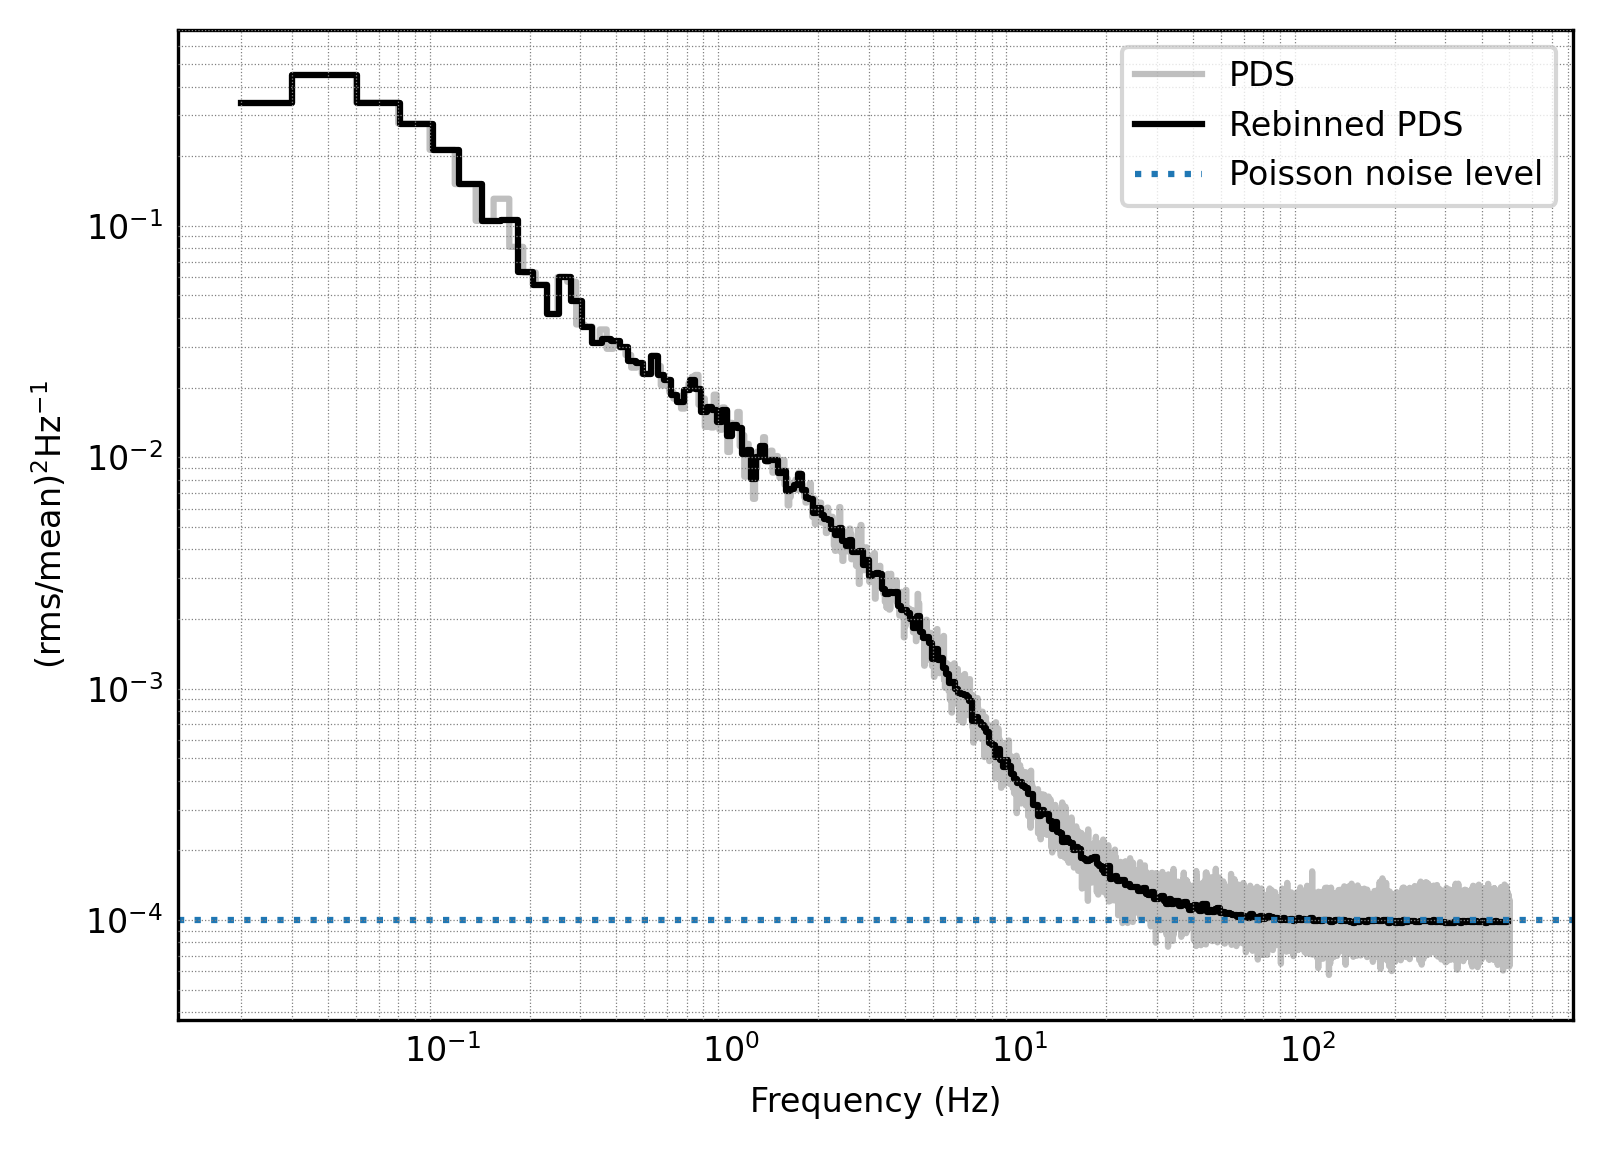

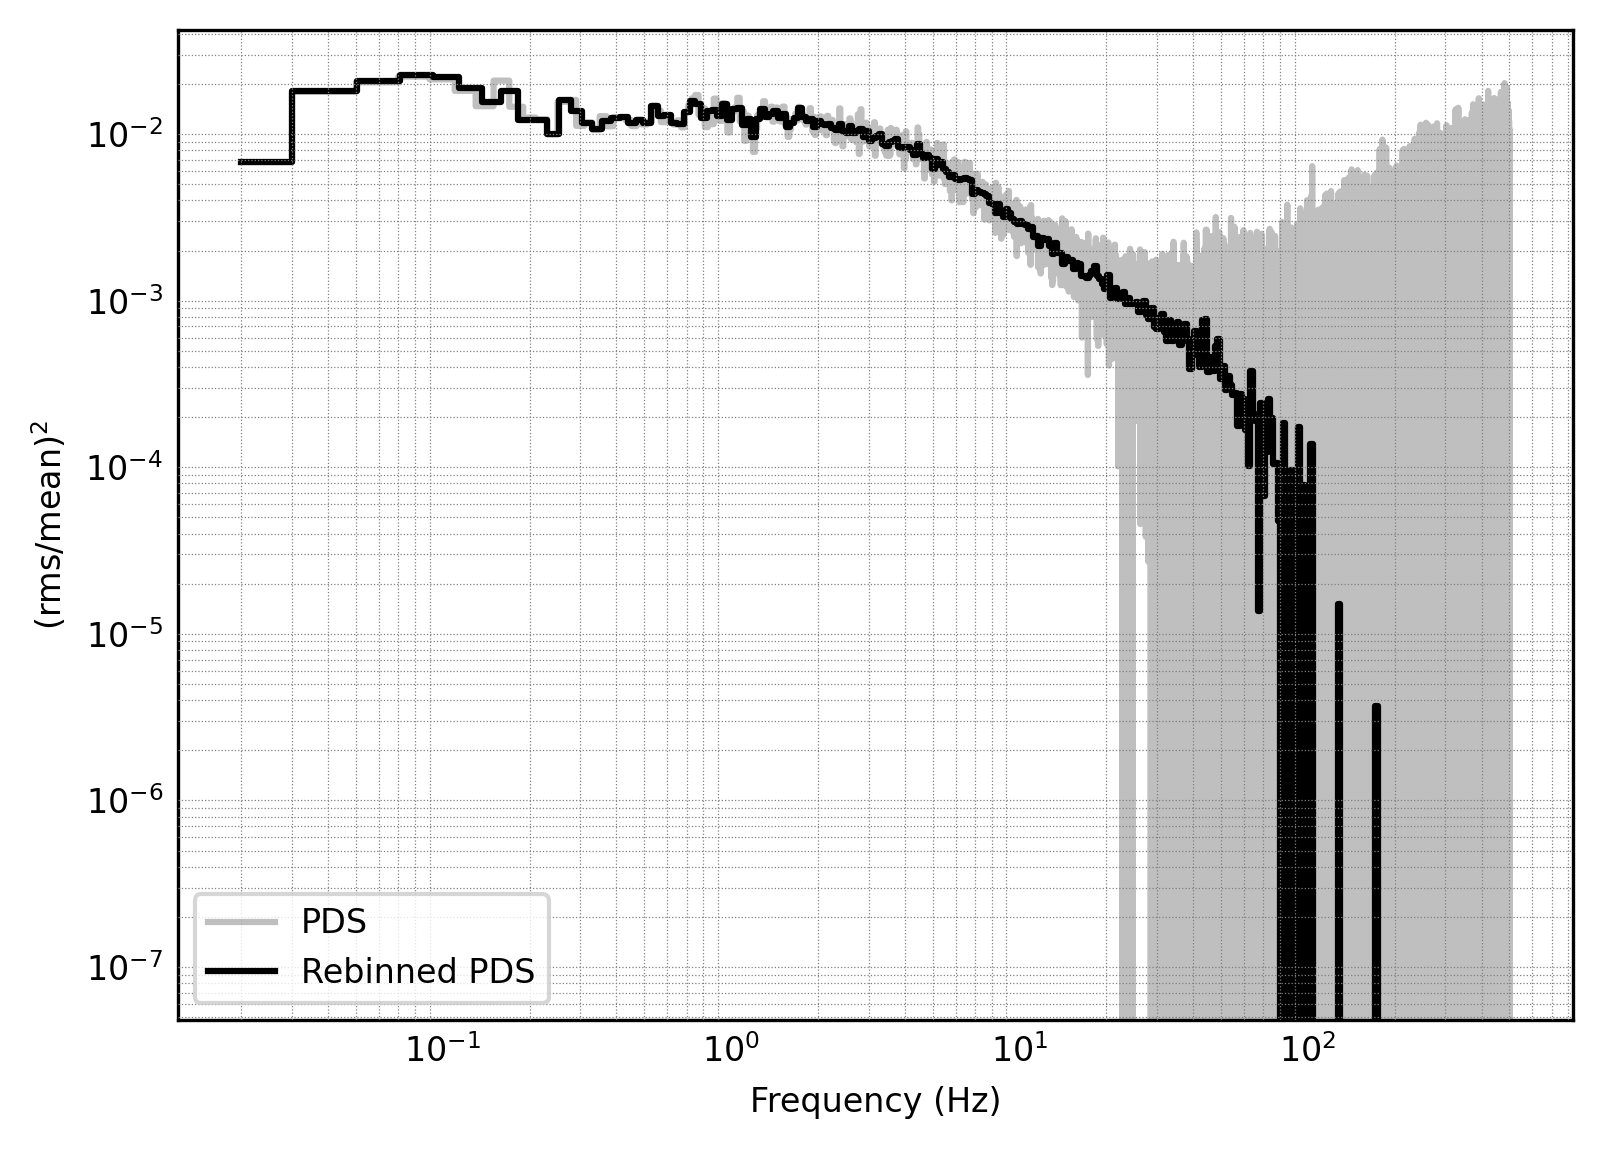

In [8]:
plt.figure()

plt.plot(pds.freq, pds.power, drawstyle="steps-mid", color="grey", alpha=0.5, label="PDS")
plt.plot(pds_reb.freq, pds_reb.power, drawstyle="steps-mid", color="k", label="Rebinned PDS")
plt.axhline(noise, ls=":", label="Poisson noise level")
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2 Hz^{-1}}$");
plt.legend()

plt.figure()
plt.plot(pds.freq, (pds.power - noise) * pds.freq, drawstyle="steps-mid", color="grey", alpha=0.5, label="PDS")
plt.plot(pds_reb.freq, (pds_reb.power - noise) * pds_reb.freq, drawstyle="steps-mid", color="k", label="Rebinned PDS")
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$");
plt.legend();


We will now do the same with the cross spectrum between the bands 0.3--5 keV and 5--12 keV.

In this case, there is no need to subtract the Poisson noise level, as it is zero in the cross spectrum, provided that the energy bands do not overlap.

In [9]:
ref_band = [1.5, 3]
sub_band = [0.5, 1]
events_ref = events.filter_energy_range(ref_band)
events_sub = events.filter_energy_range(sub_band)

cs = AveragedCrossspectrum.from_events(
    events_sub, events_ref, segment_size=segment_size, 
    dt=dt, norm=norm)
cs_reb = cs.rebin_log(0.02)


65it [00:04, 14.33it/s]


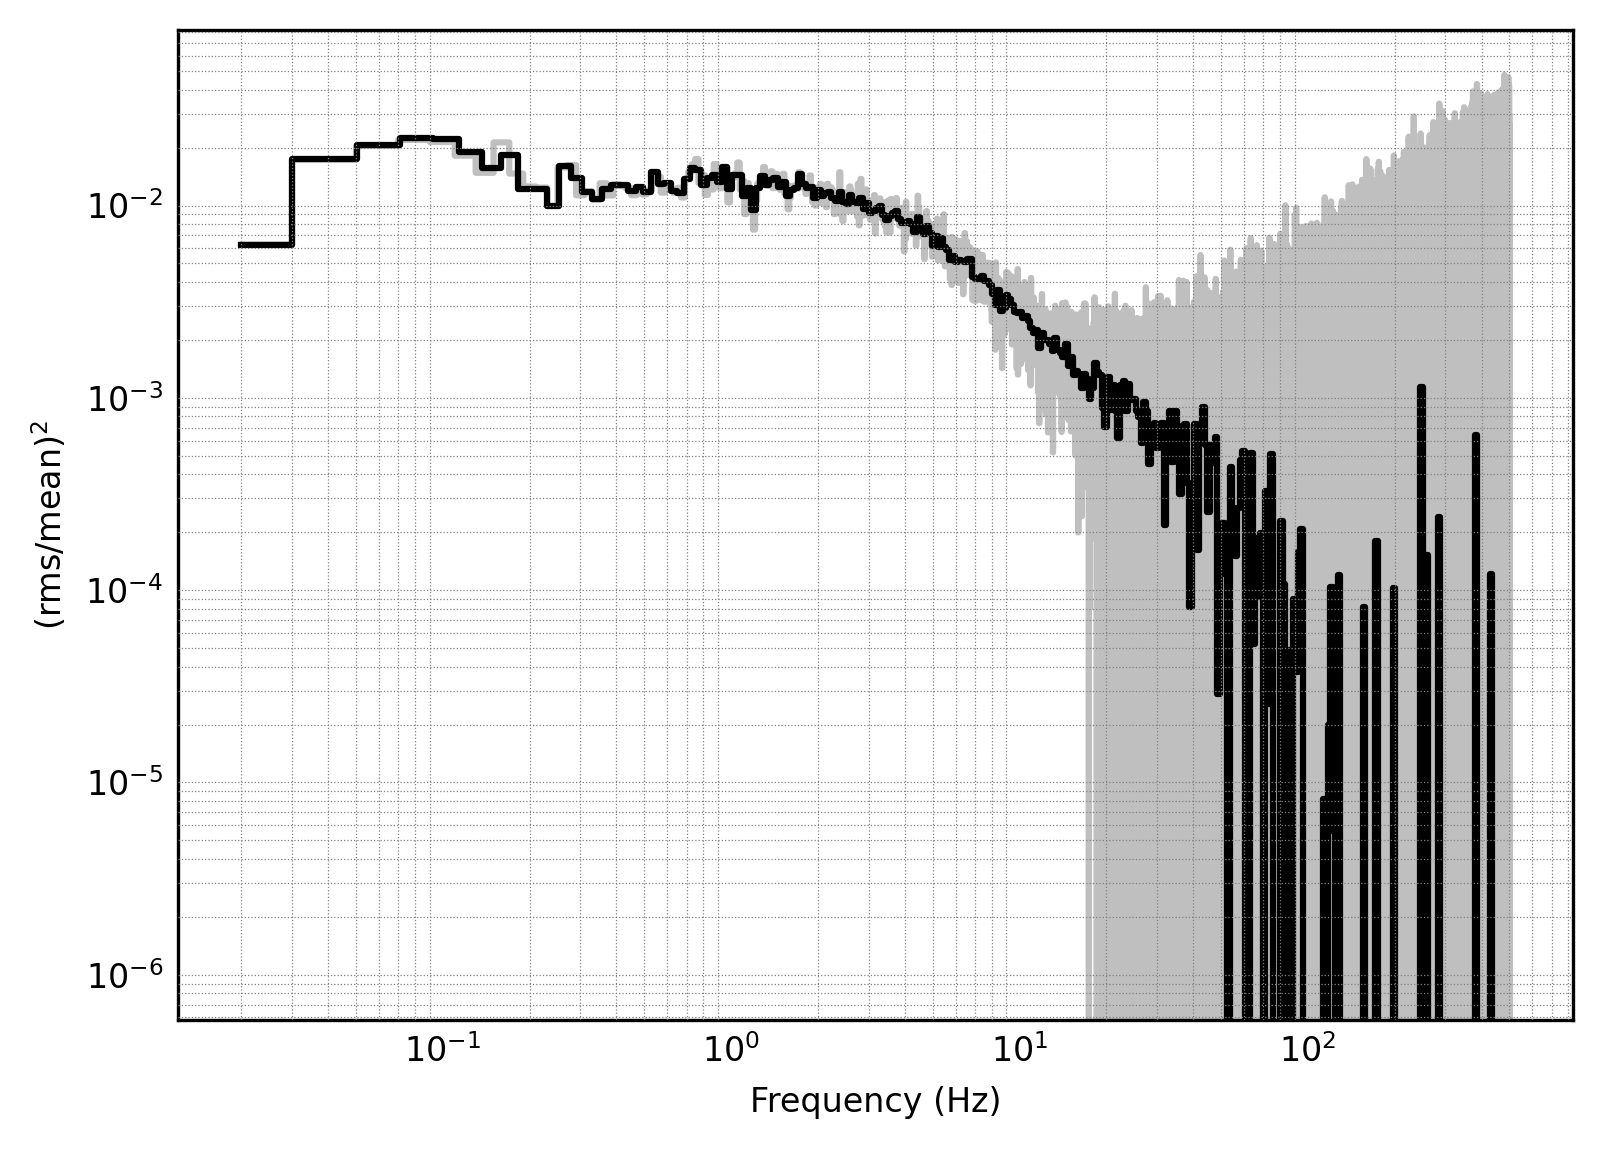

In [10]:
plt.figure()
plt.plot(cs.freq, cs.power * cs.freq, drawstyle="steps-mid", color="grey", alpha=0.5)
plt.plot(cs_reb.freq, cs_reb.power * cs_reb.freq, drawstyle="steps-mid", color="k")
plt.loglog()
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$");


## Periodogram modeling

This periodogram has a number of broad components, that can be approximated by Lorentzian curves.
Let us try to model it.


In [11]:
pds = AveragedPowerspectrum.from_events(events, segment_size=segment_size, dt=dt, norm="leahy")
pds_reb = pds.rebin_log(0.02)

65it [00:07,  8.71it/s]


We will model the periodogram using the maximum likelihood estimation from [Barret & Vaughan 2012](https://ui.adsabs.harvard.edu/abs/2012ApJ...746..131B/abstract).

For periodograms averaged over $L$ independent segments and $M$ independent neighbouring frequencies,
$$
\mathcal{L}_\mathrm{avg}(\theta) = -2ML \sum_{j=1}^{N/2} \left\{ \frac{P_j}{S_j(\theta)} + \ln{S_j(\theta) + \left( \frac{1}{ML} - 1 \right)\ln{P_j} + c(2ML) }\right\} \; ,
$$
where $\theta$ are the model parameters, $P_j$ are the periodogram values, $S_j$ the model of the underlying signal, $c(2ML)$ is a factor independent of $P_j$ or $S_j$, and thus unimportant to the parameter estimation problem considered here (it only scales the likelihood, but does not change its shape). 

For non-uniformly binned periodograms, the factor $ML$ should go inside the sum:
$$
\mathcal{L}_\mathrm{avg}(\theta) = -2\sum_{j=1}^{N/2} M_j L_j \left\{ \frac{P_j}{S_j(\theta)} + \ln{S_j(\theta) + \left( \frac{1}{ M_j L_j } - 1 \right)\ln{P_j} + c(2 M_j L_j ) }\right\} 
$$

This is the formula that we will apply here.

Let us now create an initial model that more or less describes the periodogram

(0.0, 484.10457508609966)

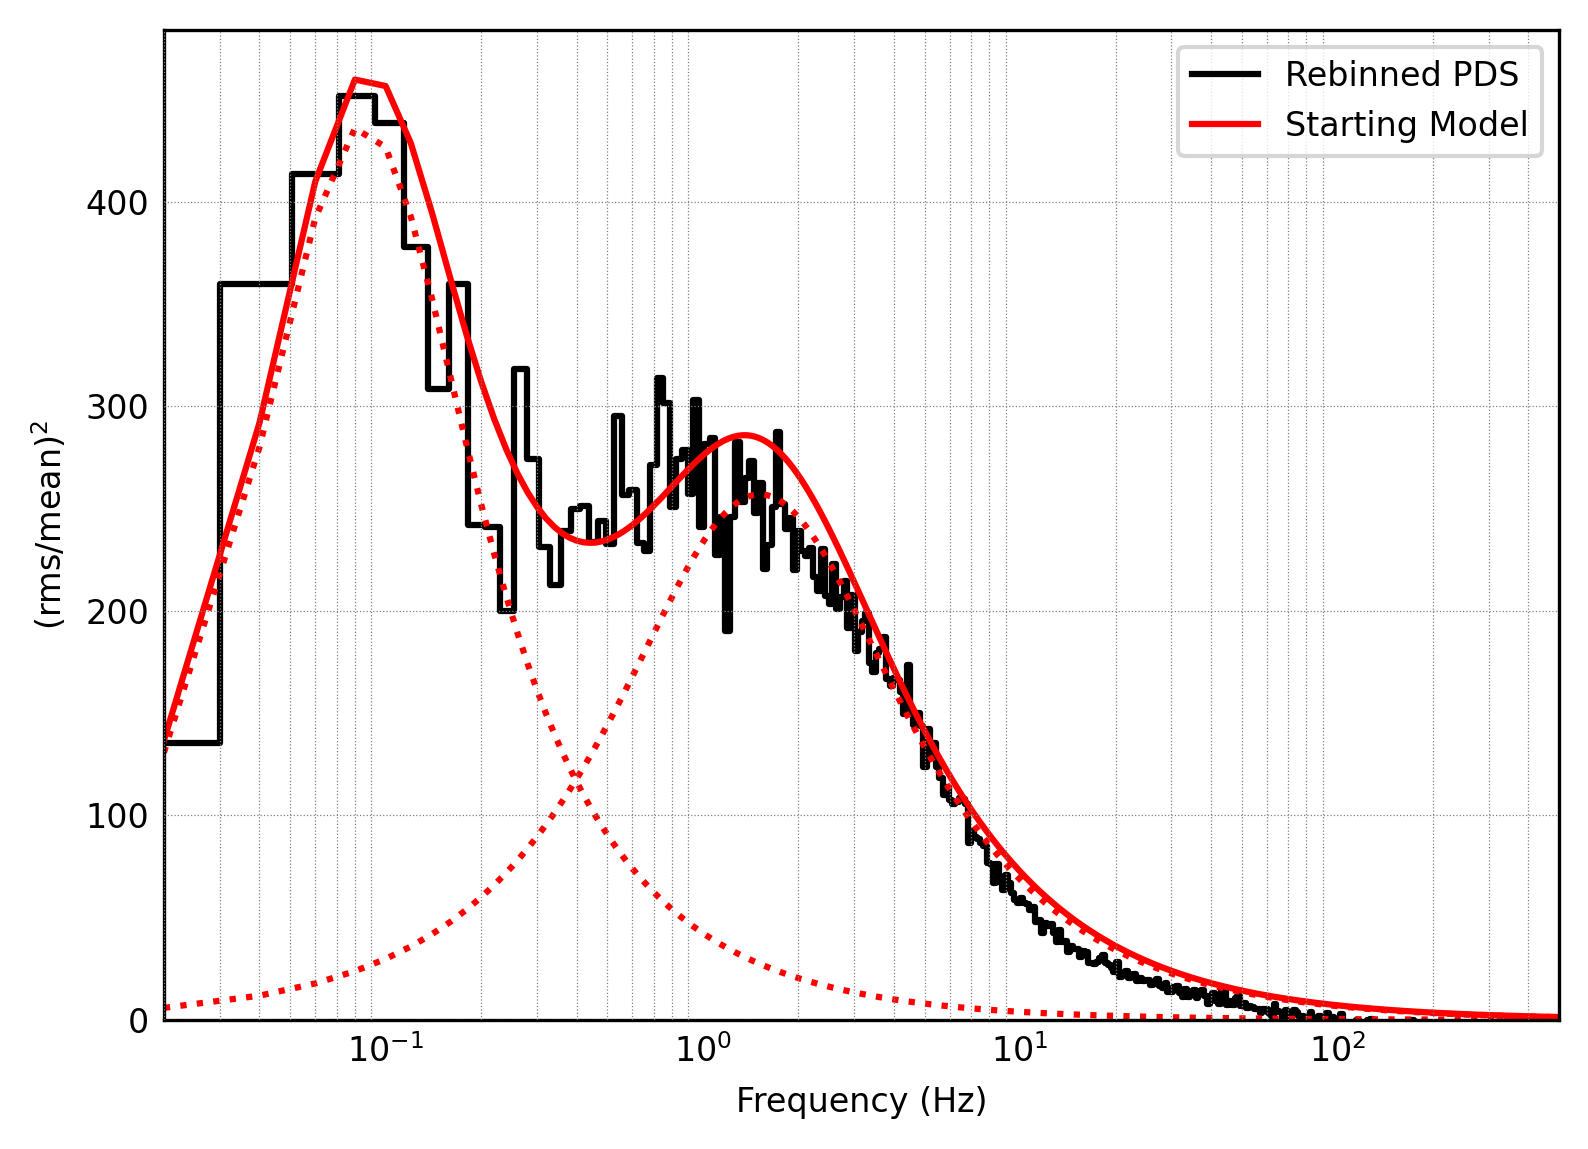

In [12]:
fit_model = models.Lorentz1D(x_0=0.04, fwhm=0.15, amplitude=7000) + \
    models.Lorentz1D(x_0=0.2, fwhm=3, amplitude=300)

plt.figure()
plt.plot(pds_reb.freq, (pds_reb.power - 2) * pds_reb.freq, drawstyle="steps-mid", color="k", label="Rebinned PDS")
plt.plot(pds.freq, fit_model(pds.freq) * pds.freq, color="r", label="Starting Model")
for mod in fit_model:
    plt.plot(pds.freq, mod(pds.freq) * pds.freq, color="r", ls=":")
    
plt.semilogx()
plt.xlim([pds.freq[0], pds.freq[-1]])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"$\mathrm{(rms / mean)^2}$");
plt.legend();
plt.ylim([0, None])


We will now add a constant at the Poisson noise level (2 in Leahy normalization) and fit using the Maximum Likelihood estimation in `stingray`

In [13]:
from stingray.modeling import PSDParEst
fit_model = models.Const1D(amplitude=2) + fit_model

parest = PSDParEst(pds_reb, fitmethod="L-BFGS-B", max_post=False)
loglike = PSDLogLikelihood(
    pds_reb.freq, pds_reb.power, fit_model, m=pds_reb.m)

res = parest.fit(loglike, fit_model.parameters)

fitmod = res.model

# The Poisson noise level was the first parameter.
poisson = fitmod.parameters[0]
print(res.p_opt)

[1.94928071e+00 6.99488338e+03 4.26318650e-02 1.39442425e-01
 2.98887410e+02 4.39209528e-01 2.62391180e+00]


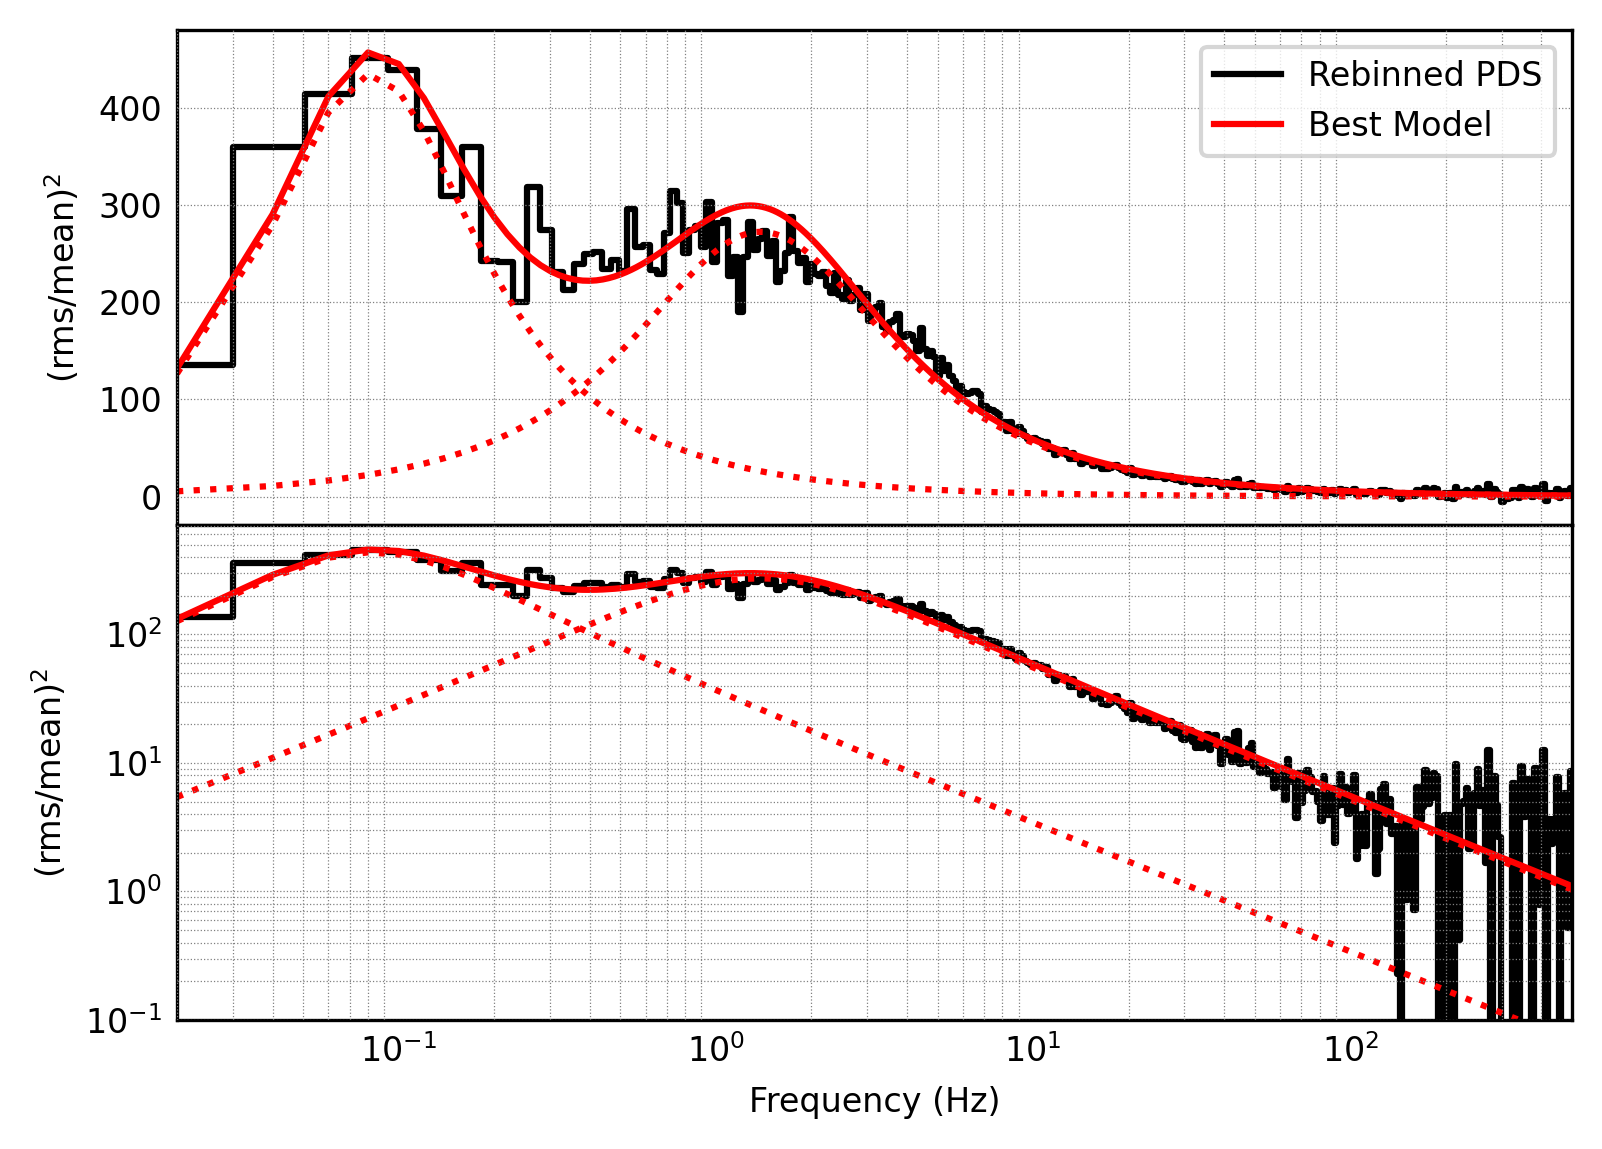

In [14]:
plt.figure()
gs = plt.GridSpec(2, 1, hspace=0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

ax0.plot(pds_reb.freq, (pds_reb.power - poisson) * pds_reb.freq, drawstyle="steps-mid", color="k", label="Rebinned PDS")
ax0.plot(pds.freq, (fitmod(pds.freq) - poisson) * pds.freq, color="r", label="Best Model")
for mod in fitmod[1:]:
    ax0.plot(pds.freq, mod(pds.freq) * pds.freq, color="r", ls=":")
    
ax0.set_xlabel("Frequency (Hz)")
ax0.set_ylabel(r"$\mathrm{(rms / mean)^2}$");
ax0.legend();

ax1.plot(pds_reb.freq, (pds_reb.power - poisson) * pds_reb.freq, drawstyle="steps-mid", color="k", label="Rebinned PDS")
ax1.plot(pds.freq, (fitmod(pds.freq) - poisson) * pds.freq, color="r", label="Best Model")
for mod in fitmod[1:]:
    ax1.plot(pds.freq, mod(pds.freq) * pds.freq, color="r", ls=":")
    
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel(r"$\mathrm{(rms / mean)^2}$");
ax1.loglog()
ax1.set_ylim([1e-1, None]);
ax1.set_xlim([pds.freq[0], pds.freq[-1]]);

## Lags and coherence

With the cross spectrum we can explore the time lags versus frequency

In [15]:
# Use shorter segments, rebin a little more heavily
cs = AveragedCrossspectrum.from_events(events_sub, events_ref, segment_size=2, dt=0.01, norm=norm)
cs_reb = cs.rebin_log(0.4)

lag, lag_e = cs_reb.time_lag()



2627it [00:07, 356.75it/s]


[]

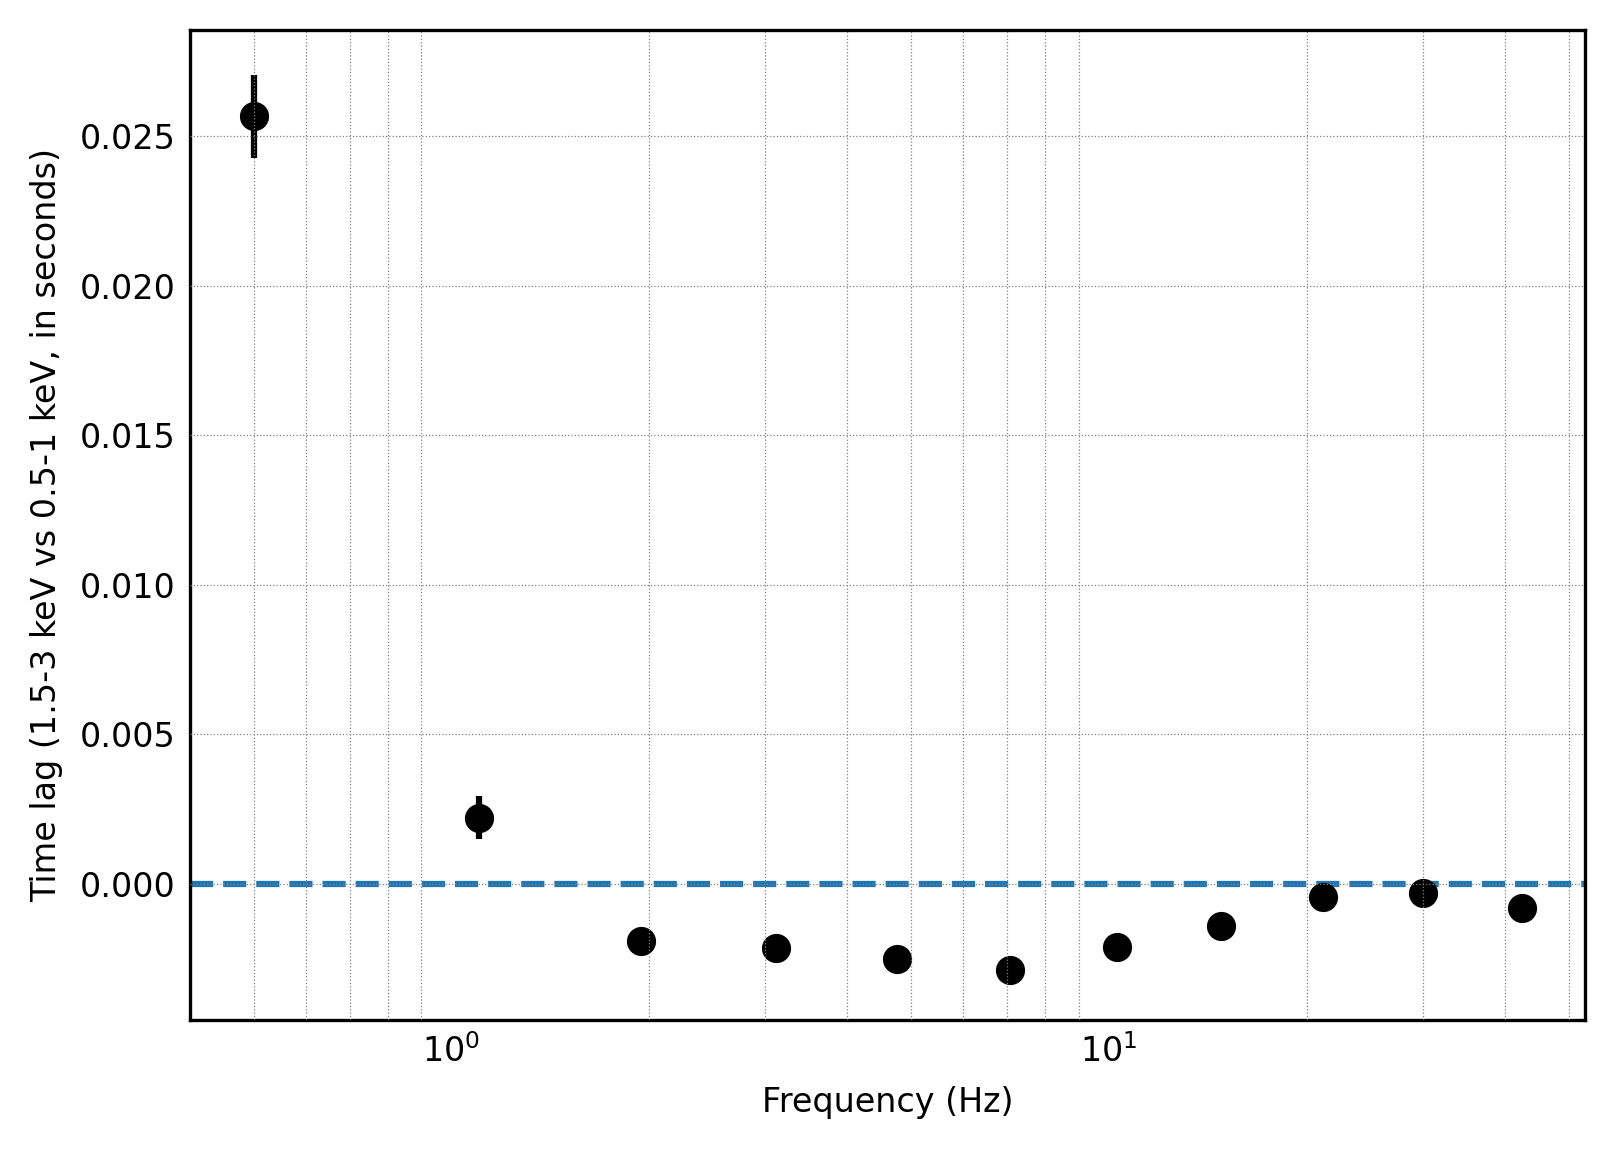

In [16]:
plt.figure()
plt.errorbar(cs_reb.freq, lag, yerr=lag_e, fmt="o", color="k")
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"Time lag ({ref_band[0]:g}-{ref_band[1]:g} keV vs {sub_band[0]:g}-{sub_band[1]:g} keV, in seconds)")
plt.axhline(0, ls="--")
plt.semilogx()
# plt.ylim([1e-4, None]);
# plt.xlim([None, 80])
# plt.legend();

Another interesting thing to measure is the coherence at different frequencies

[]

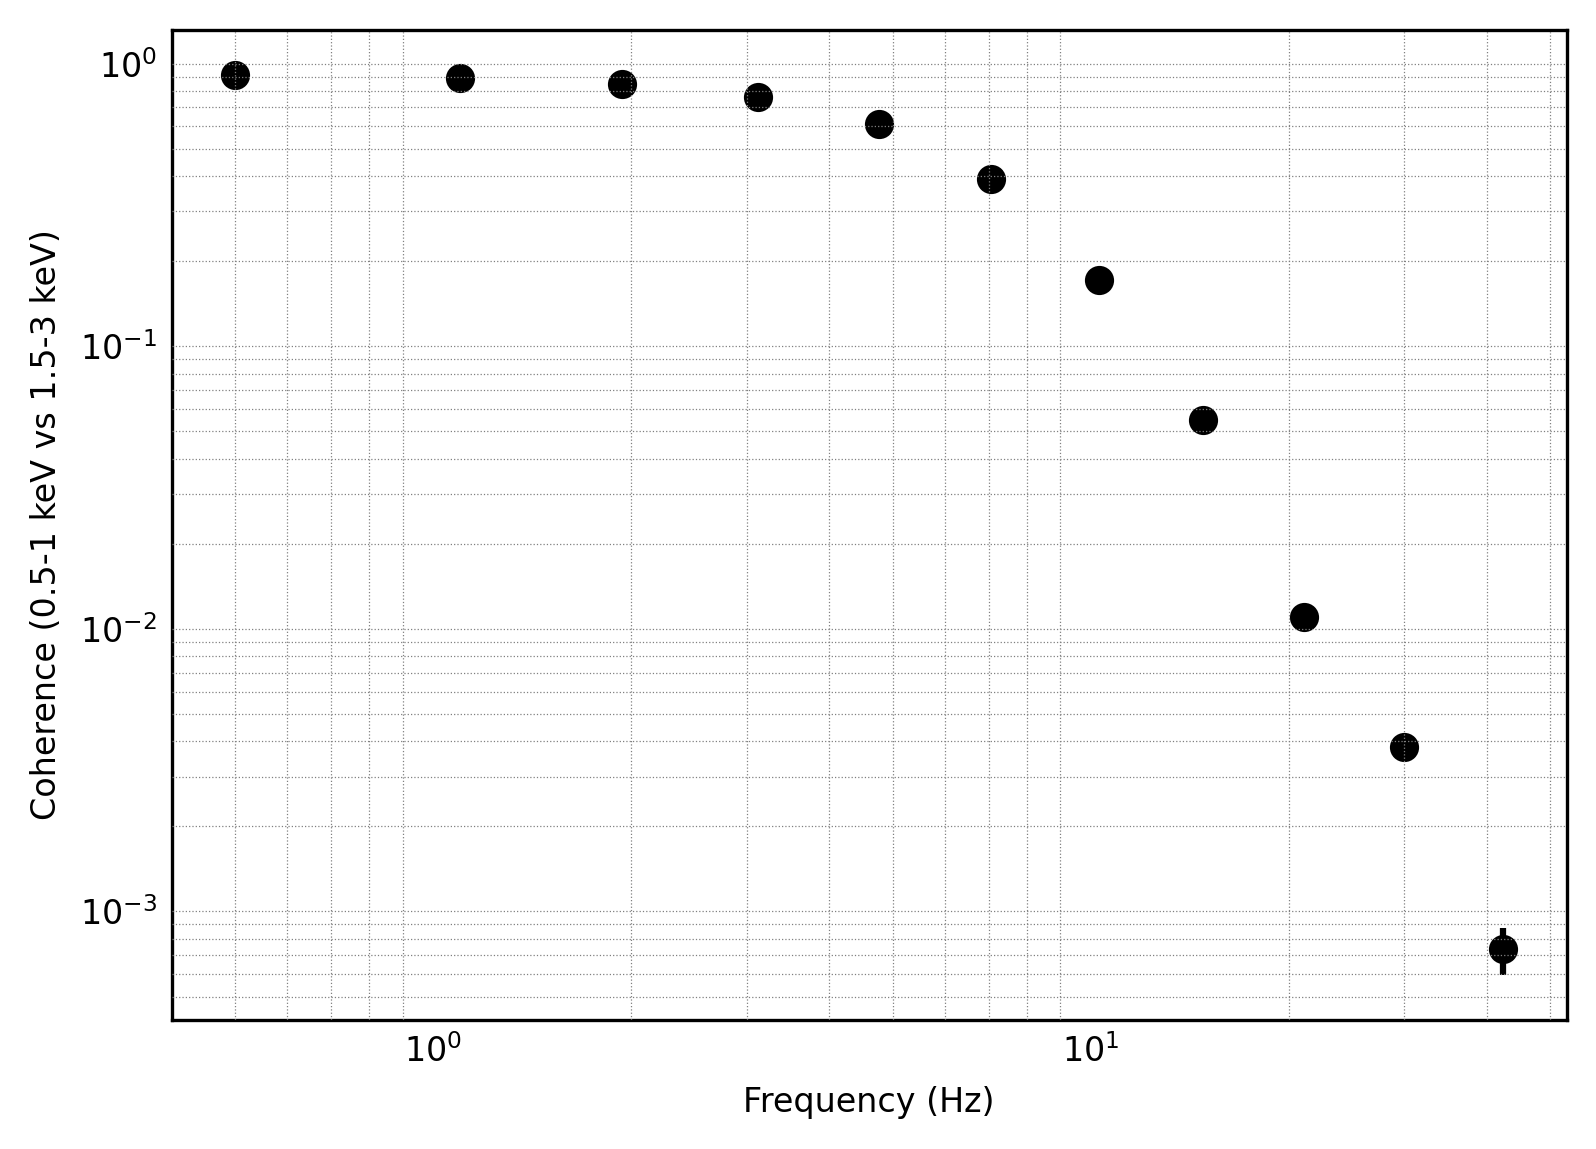

In [17]:
coh, coh_e = cs_reb.coherence()
plt.figure()
plt.errorbar(cs_reb.freq, coh, yerr=coh_e, fmt="o", color="k")
plt.xlabel("Frequency (Hz)")
plt.ylabel(f"Coherence ({sub_band[0]:g}-{sub_band[1]:g} keV vs {ref_band[0]:g}-{ref_band[1]:g} keV)")
plt.axhline(0, ls="--")
plt.loglog()
# plt.ylim([1e-4, None]);
# plt.xlim([None, 80])
# plt.legend();

# Spectral timing

Now let us explore the spectral timing properties of this observation, with no physical interpretation, just for the sake of data exploration.

In [18]:
from stingray.varenergyspectrum import CountSpectrum, CovarianceSpectrum, RmsSpectrum, LagSpectrum

Let us start with the lag spectrum with respect to energy, in different frequency bands.
This might be confusing for people coming from other wavelengths, so let us specify that

+ "frequency" refers to the frequency of the variability.

+ "energy" refers to the photon energy.

The photons at 0.3-12 keV are modulated by oscillations and other stochastic noise up to ~100 Hz (see section above). As an example, we will now analyze the spectral timing properties using the variability up to 1 Hz and between 4 and 10 Hz.

From Kara+2019, figure 3

In [19]:
energy_spec = np.geomspace(0.5, 10, 41)
segment_size = 10
bin_time = 0.001
freq_interval = [3, 30]
ref_band=[0.5, 10]

# If not specified, the reference energy band is the whole band.

lagspec_3_30 = LagSpectrum(events, freq_interval=freq_interval, 
                          segment_size=segment_size, bin_time=bin_time,
                          energy_spec=energy_spec, ref_band=ref_band)
lagspec_3_30.spectrum *= -1
energies = lagspec_3_30.energy



100%|████████████████████████████████████████████████████| 40/40 [07:12<00:00, 10.81s/it]


[]

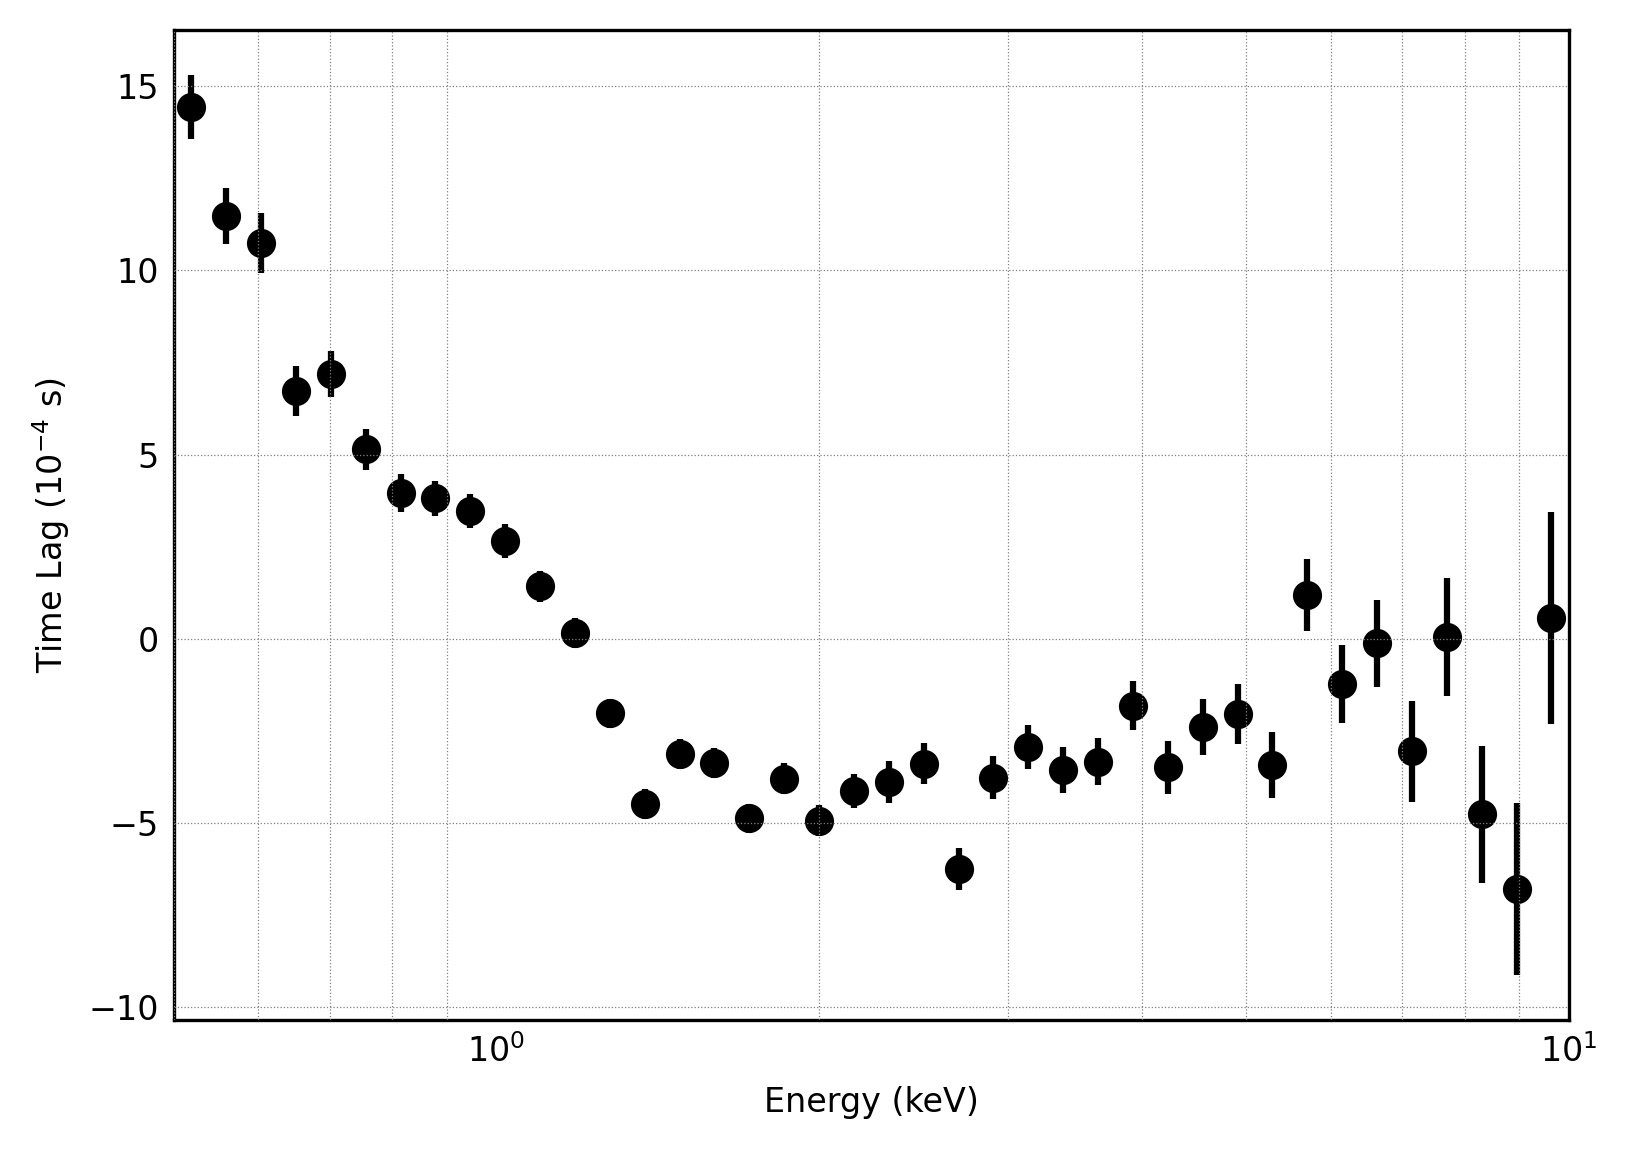

In [20]:
plt.figure()
plt.errorbar(energies, lagspec_3_30.spectrum * 1e4, yerr=lagspec_3_30.spectrum_error * 1e4, fmt='o', label="3-30 Hz", color="k")
plt.xlabel("Energy (keV)")
plt.ylabel("Time Lag ($10^{-4}$ s)")
plt.xlim([0.5, 10])
plt.semilogx()

In [21]:
lagspec_01_1 = LagSpectrum(events, freq_interval=[0.1, 1], 
                           segment_size=segment_size, bin_time=bin_time,
                           energy_spec=energy_spec, ref_band=ref_band)
lagspec_01_1.spectrum *= -1
energies = lagspec_01_1.energy
energies_err = np.diff(lagspec_01_1.energy_intervals, axis=1).flatten() / 2



100%|████████████████████████████████████████████████████| 40/40 [07:10<00:00, 10.76s/it]


Text(0, 0.5, 'Time lag (s)')

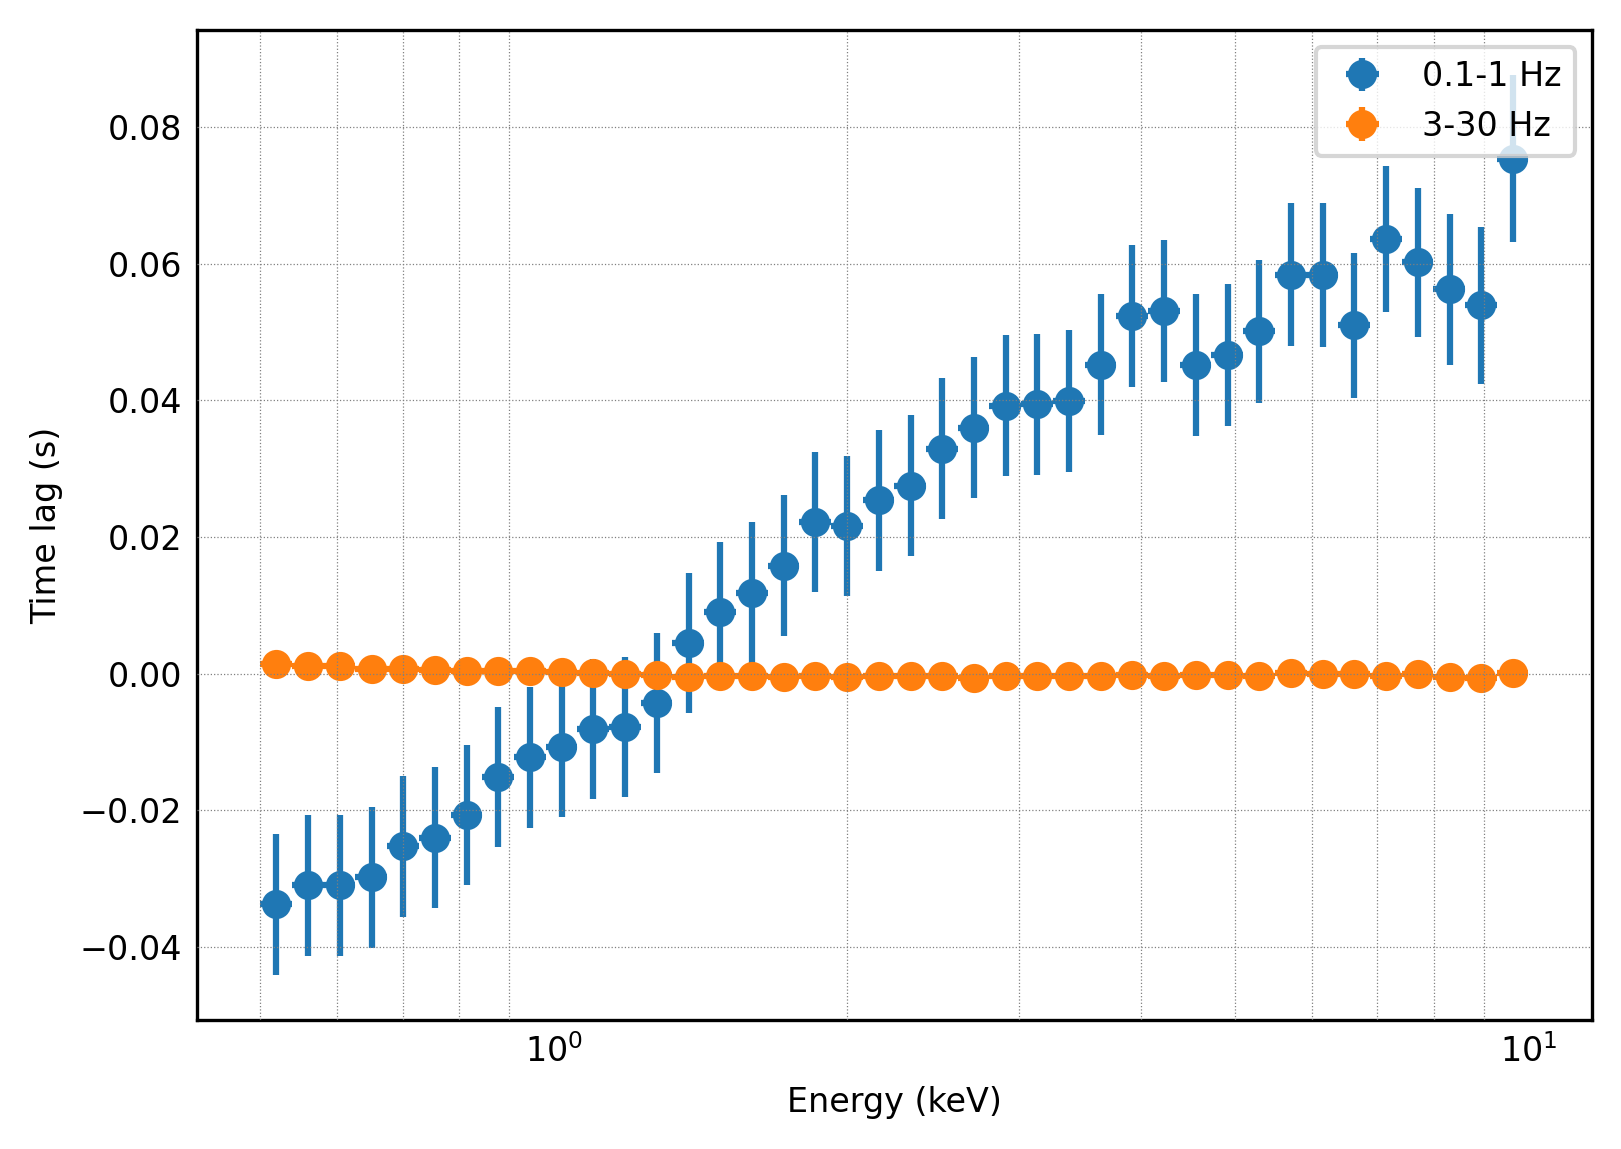

In [22]:
plt.figure()
plt.errorbar(energies, lagspec_01_1.spectrum, xerr=energies_err, yerr=lagspec_01_1.spectrum_error, fmt='o', label="0.1-1 Hz")
plt.errorbar(energies, lagspec_3_30.spectrum, xerr=energies_err, yerr=lagspec_3_30.spectrum_error, fmt='o', label="3-30 Hz")
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Time lag (s)")

Text(0, 0.5, 'Phase lag (rad)')

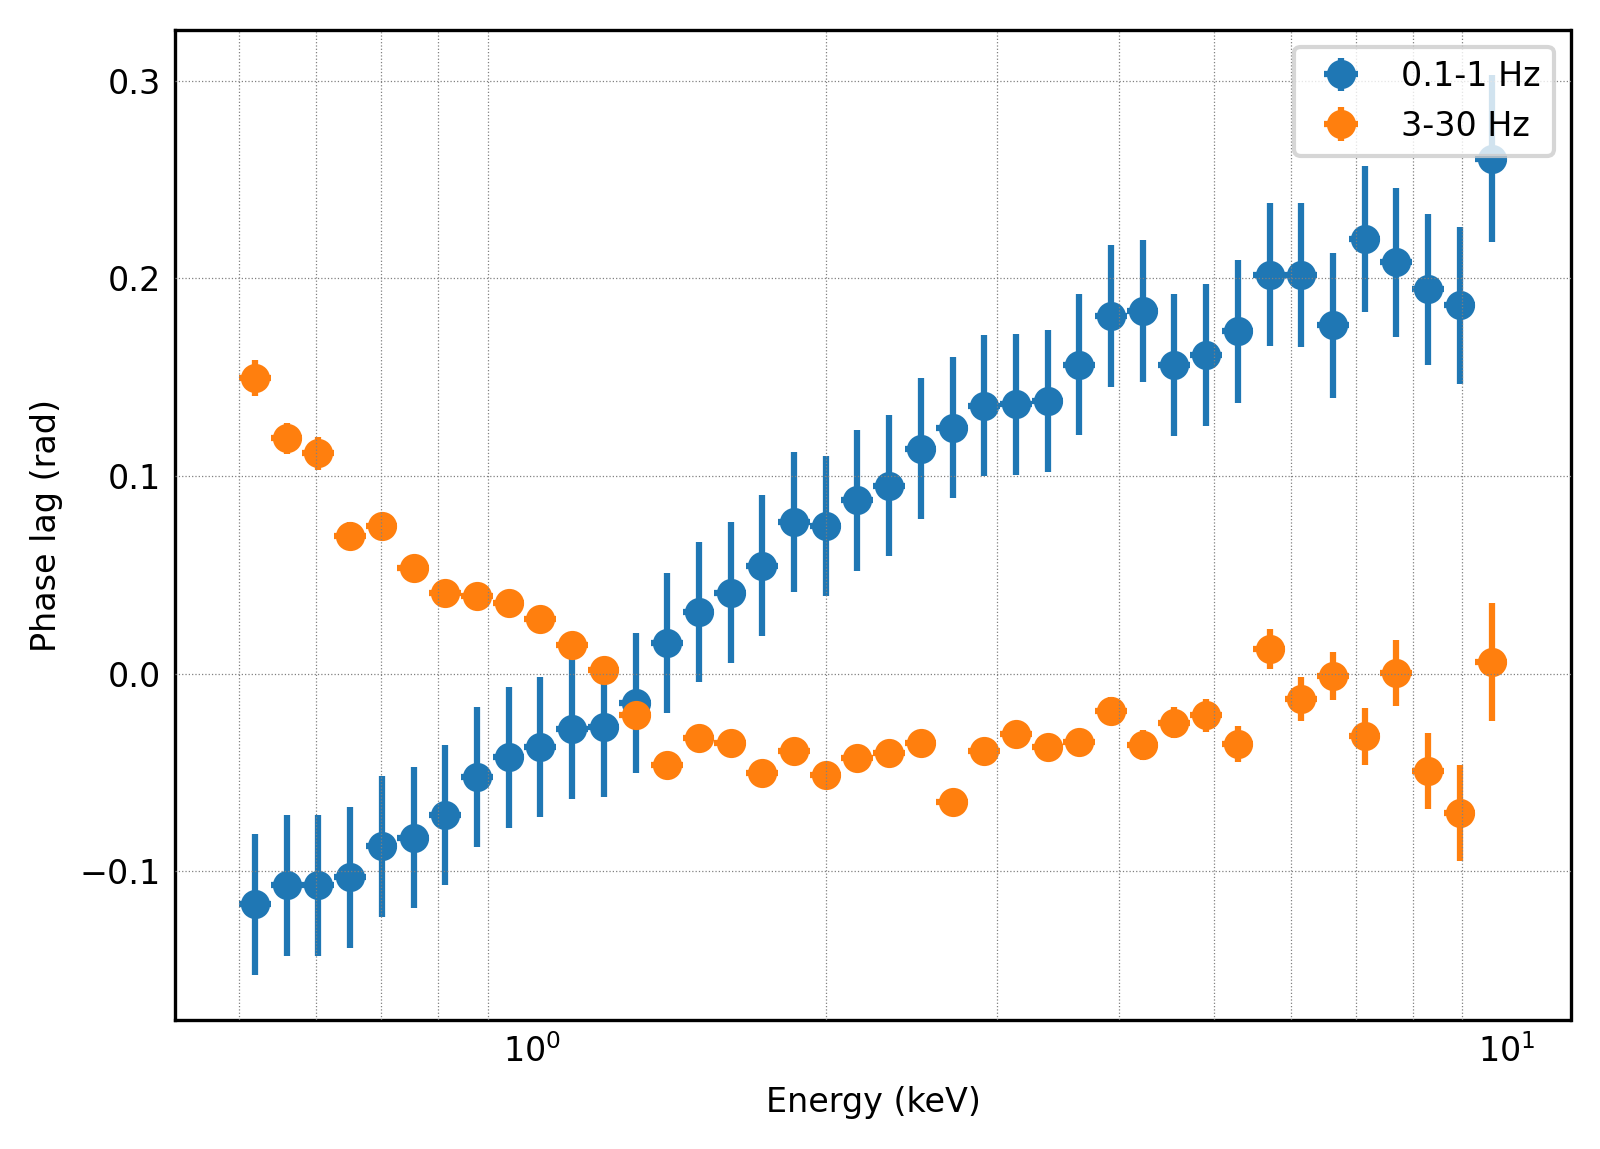

In [23]:
freq_01_1 = (1 + 0.1) / 2 * 2 * np.pi
freq_3_30 = (3 + 30) / 2 * 2 * np.pi
plt.figure()
plt.errorbar(energies, lagspec_01_1.spectrum * freq_01_1 , xerr=energies_err, yerr=lagspec_01_1.spectrum_error * freq_01_1, fmt='o', label="0.1-1 Hz")
plt.errorbar(energies, lagspec_3_30.spectrum * freq_3_30, xerr=energies_err, yerr=lagspec_3_30.spectrum_error * freq_3_30, fmt='o', label="3-30 Hz")
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Phase lag (rad)")

Interesting: the low-frequency variability has much longer time lags than the high-frequency variability, but the phase lags are on the same order of magnitude.

## Covariance and RMS spectrum

In [24]:
covspec_3_30 = CovarianceSpectrum(events, freq_interval=[3, 30], 
                                 segment_size=segment_size, bin_time=bin_time,
                                 energy_spec=energy_spec, norm="abs", ref_band=ref_band)
covspec_01_1 = CovarianceSpectrum(events, freq_interval=[0.1, 1], 
                                  segment_size=segment_size, bin_time=bin_time,
                                  energy_spec=energy_spec, norm="abs", ref_band=ref_band)


100%|████████████████████████████████████████████████████| 40/40 [07:12<00:00, 10.82s/it]


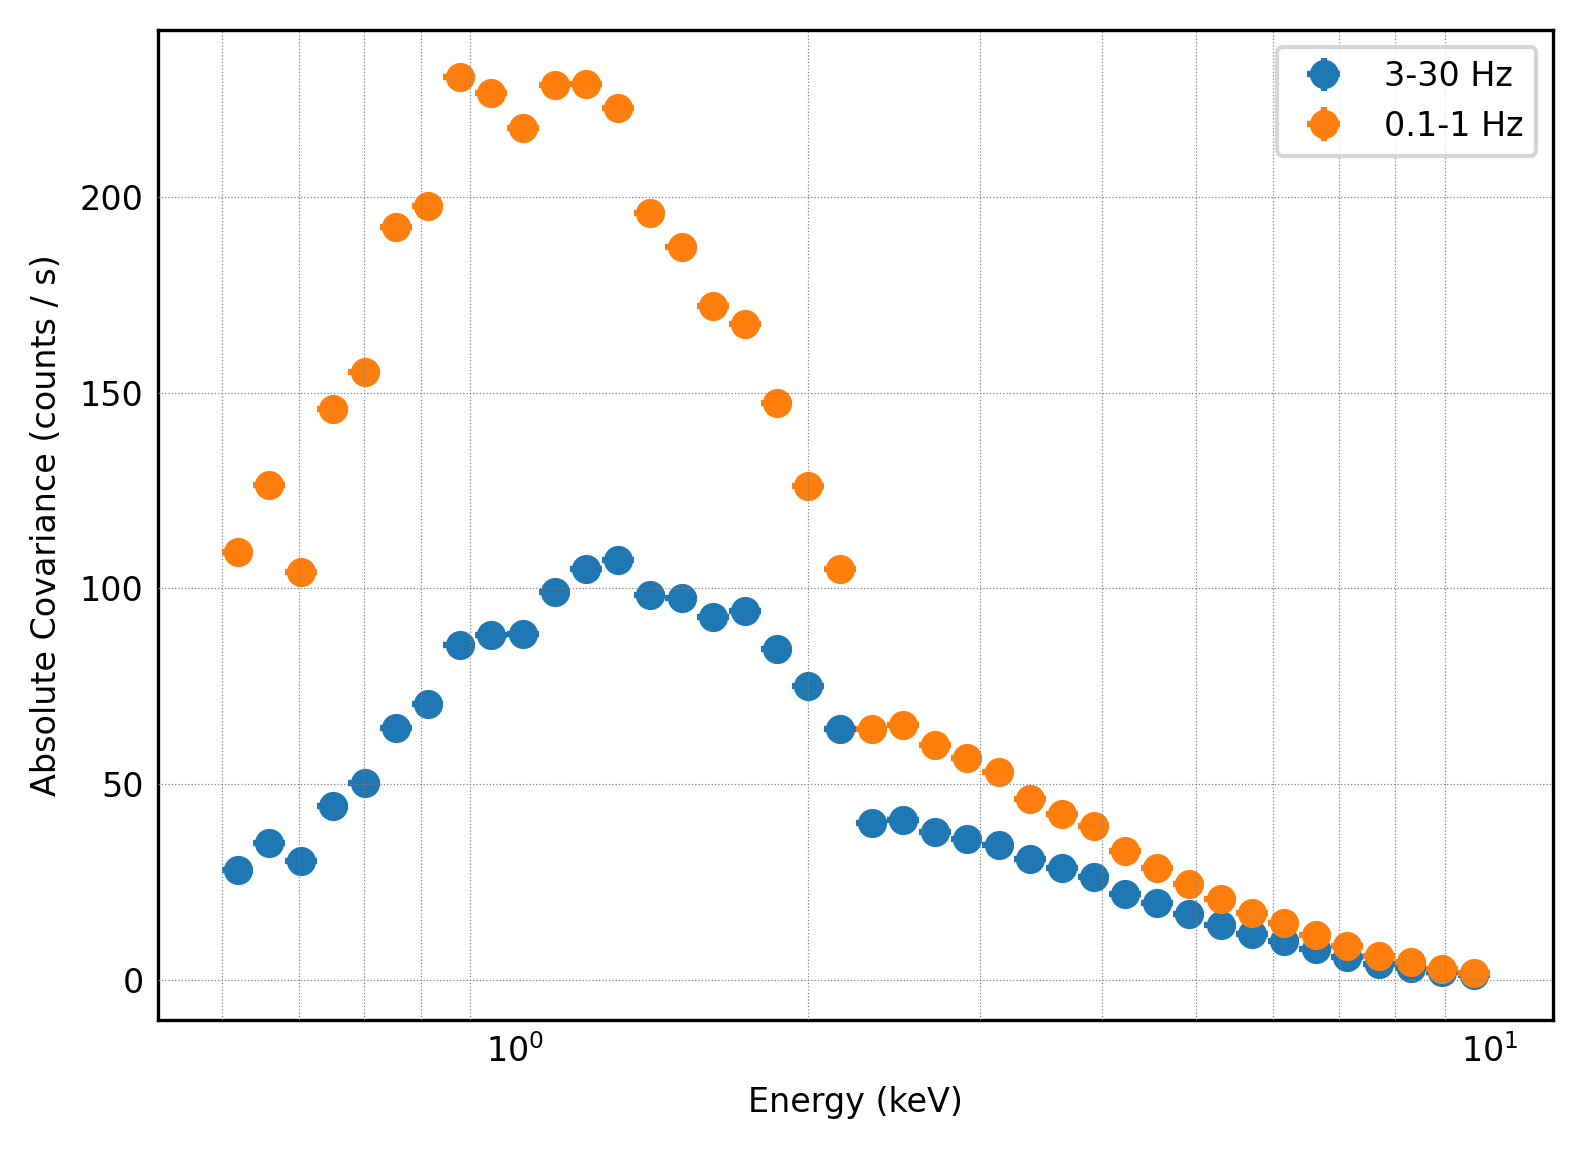

In [25]:
plt.figure()
plt.errorbar(energies, covspec_3_30.spectrum, 
             xerr=energies_err, yerr=covspec_3_30.spectrum_error, fmt='o', label="3-30 Hz")
plt.errorbar(energies, covspec_01_1.spectrum, 
             xerr=energies_err, yerr=covspec_01_1.spectrum_error, fmt='o', label="0.1-1 Hz")
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Absolute Covariance (counts / s)");

This covariance, plotted this way, mostly tracks the number of counts in each energy bin. To get an unfolded covariance, we need to use the response of the instrument. Another way is to plot the fractional covariance, normalizing by the number of counts in each bin.

To do this, we calculate the Count Spectrum and divide by it.

In [26]:
countsp = CountSpectrum(events, energy_spec=energy_spec)

40it [00:05,  7.22it/s]


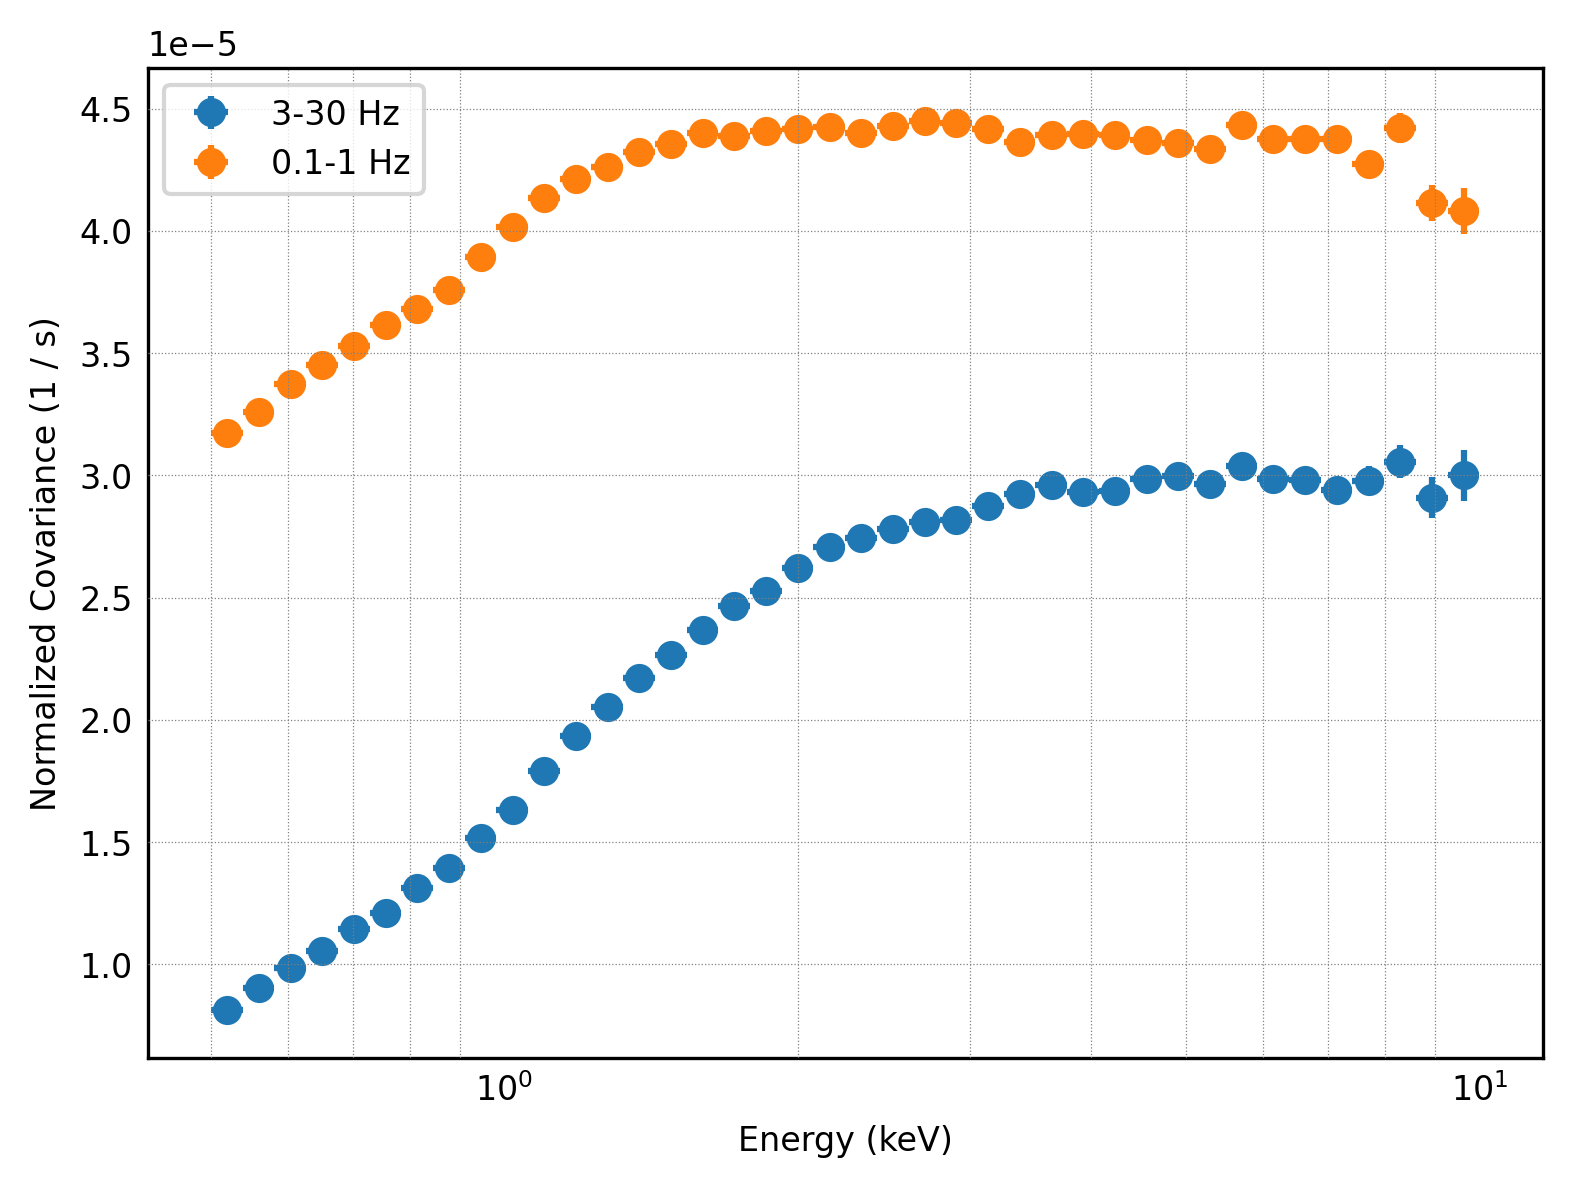

In [27]:
plt.figure()
plt.errorbar(energies, covspec_3_30.spectrum / countsp.spectrum, 
             xerr=energies_err, yerr=covspec_3_30.spectrum_error / countsp.spectrum, fmt='o', label="3-30 Hz")
plt.errorbar(energies, covspec_01_1.spectrum / countsp.spectrum, 
             xerr=energies_err, yerr=covspec_01_1.spectrum_error / countsp.spectrum, fmt='o', label="0.1-1 Hz")
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Normalized Covariance (1 / s)");

Alternatively, we can calculate the Covariance Spectrum in fractional rms normalization

In [28]:
covspec_01_1 = CovarianceSpectrum(events, freq_interval=[0.1, 1], 
                                 segment_size=segment_size, bin_time=bin_time,
                                 energy_spec=energy_spec, norm="frac")
covspec_3_30 = CovarianceSpectrum(events, freq_interval=[3, 30], 
                                  segment_size=segment_size, bin_time=bin_time,
                                  energy_spec=energy_spec, norm="frac")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [07:58<00:00, 11.97s/it]


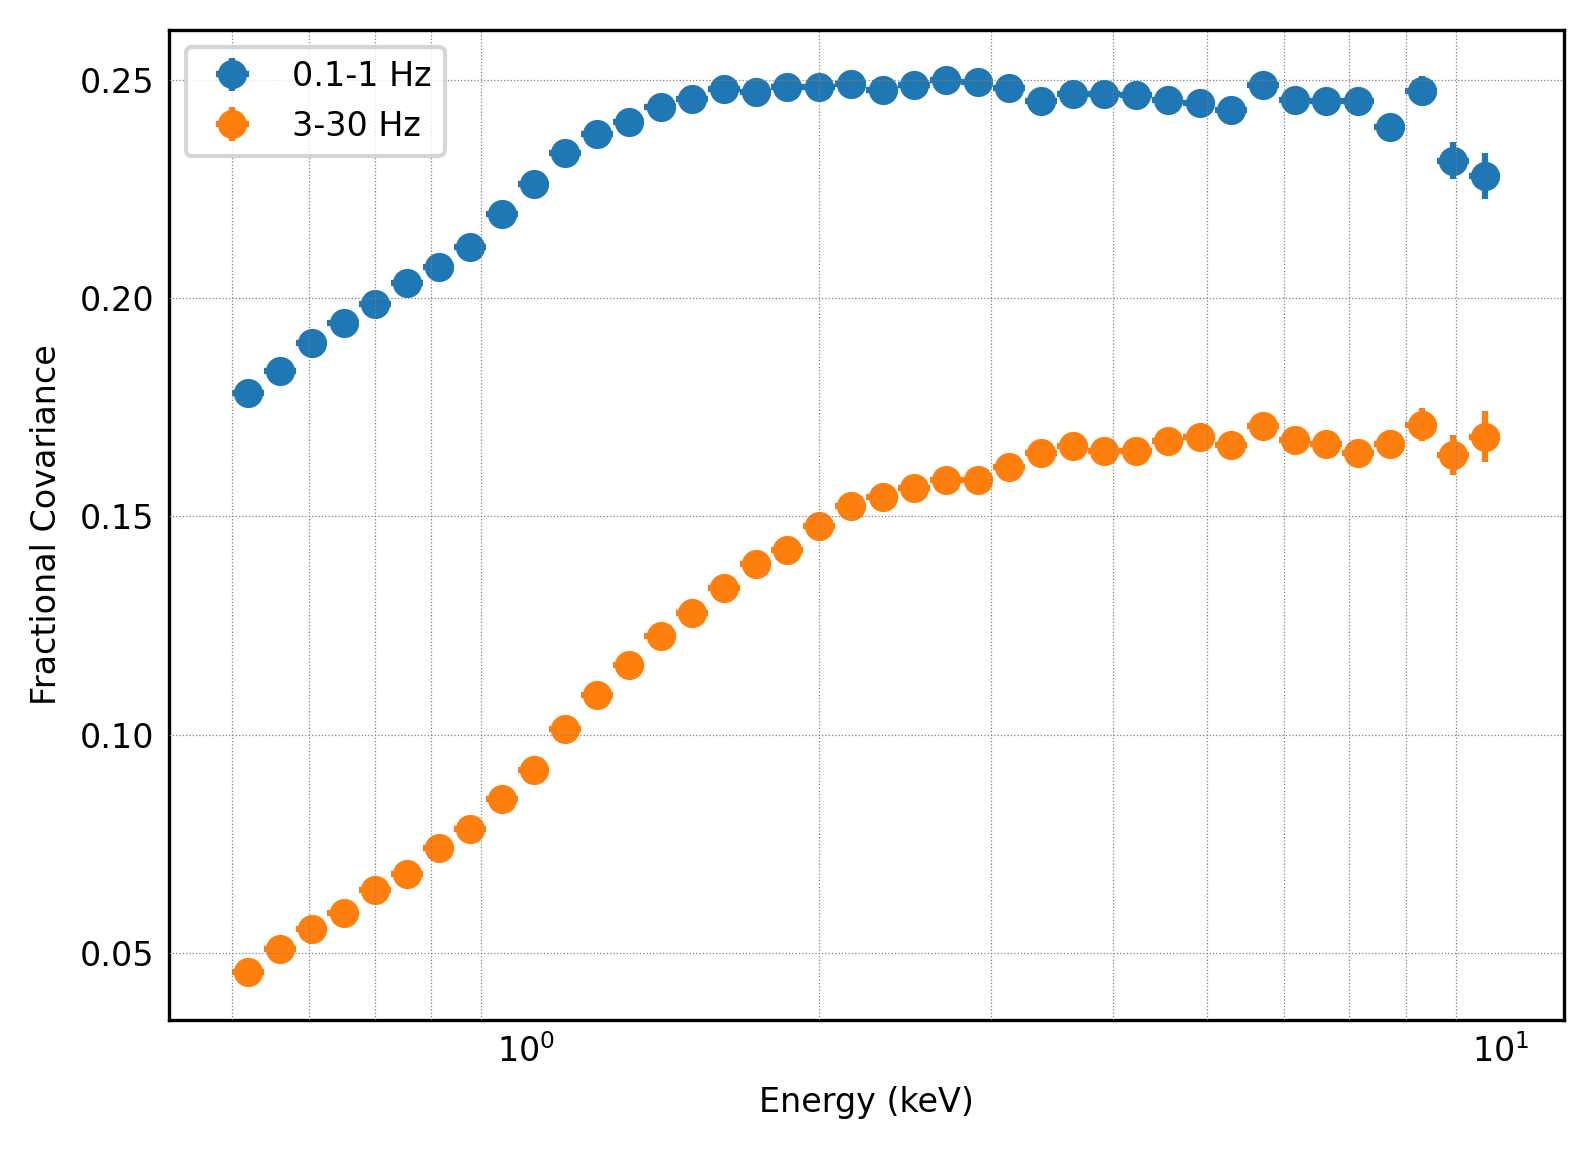

In [29]:
plt.figure()
plt.errorbar(energies, covspec_01_1.spectrum, 
             xerr=energies_err, yerr=covspec_01_1.spectrum_error, fmt='o', label="0.1-1 Hz")
plt.errorbar(energies, covspec_3_30.spectrum, 
             xerr=energies_err, yerr=covspec_3_30.spectrum_error, fmt='o', label="3-30 Hz")
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Fractional Covariance");

This should largely be equivalent to the RMS spectrum

In [30]:
rmsspec_01_1 = RmsSpectrum(events, freq_interval=[0.1, 1], 
                          segment_size=segment_size, bin_time=bin_time,
                          energy_spec=energy_spec, norm="frac")
rmsspec_3_30 = RmsSpectrum(events, freq_interval=[3, 30], 
                           segment_size=segment_size, bin_time=bin_time,
                           energy_spec=energy_spec, norm="frac")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:18<00:00,  2.14it/s]


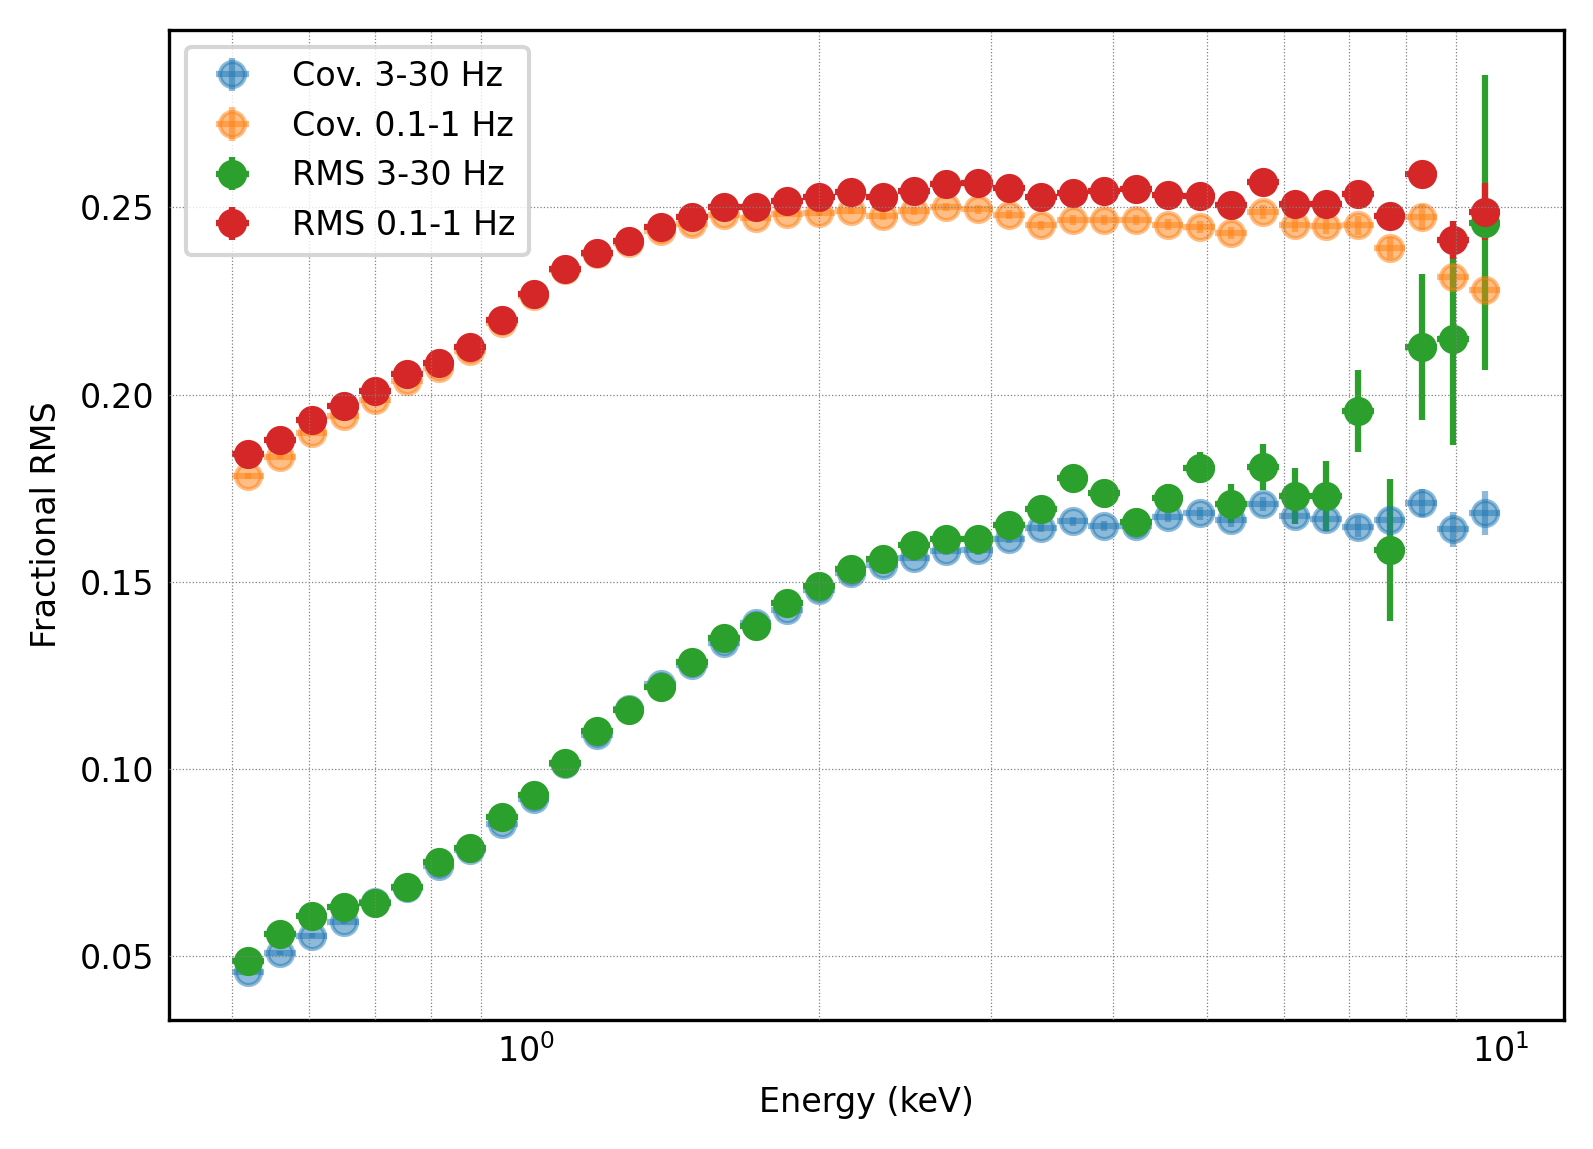

In [31]:
plt.figure()
plt.errorbar(energies, covspec_3_30.spectrum, 
             xerr=energies_err, yerr=covspec_3_30.spectrum_error, fmt='o', label="Cov. 3-30 Hz", alpha=0.5)
plt.errorbar(energies, covspec_01_1.spectrum, 
             xerr=energies_err, yerr=covspec_01_1.spectrum_error, fmt='o', label="Cov. 0.1-1 Hz", alpha=0.5)
plt.errorbar(energies, rmsspec_3_30.spectrum, 
             xerr=energies_err, yerr=rmsspec_3_30.spectrum_error, fmt='o', label="RMS 3-30 Hz")
plt.errorbar(energies, rmsspec_01_1.spectrum, 
             xerr=energies_err, yerr=rmsspec_01_1.spectrum_error, fmt='o', label="RMS 0.1-1 Hz")
plt.legend()
plt.semilogx()
plt.xlabel("Energy (keV)")
plt.ylabel("Fractional RMS");

QED, except that the error bars in some points look underestimated. It is always recommended to test error bars with simulations, in any case, as analytic formulas are based on a series of assumptions (in particular, on the coherence) that might not be correct in real life.

In [35]:
from stingray.varenergyspectrum import LagSpectrum
covspec_3_30 = CovarianceSpectrum(events, freq_interval=[3, 30], 
                                  segment_size=segment_size, bin_time=bin_time,
                                  energy_spec=energy_spec, norm="frac")


39795.45731958763 38991.099301682116 1768.0772241559241


  2%|███▌                                                                                                                                          | 1/40 [00:12<08:00, 12.32s/it]

1234.7740206185567 1233.9159374354088 57.705366350269095


  5%|███████                                                                                                                                       | 2/40 [00:24<07:48, 12.33s/it]

1386.7917525773196 1386.437706990305 66.11125381670774


  8%|██████████▋                                                                                                                                   | 3/40 [00:36<07:31, 12.21s/it]

1102.9571134020619 1103.2734807240006 49.540853894543645


 10%|██████████████▏                                                                                                                               | 4/40 [00:49<07:24, 12.34s/it]

1506.1344329896908 1503.3163298107577 68.86737625672049


 12%|█████████████████▊                                                                                                                            | 5/40 [01:02<07:17, 12.51s/it]

1568.6688659793815 1568.9410576197936 70.89694984652415


 15%|█████████████████████▎                                                                                                                        | 6/40 [01:14<07:09, 12.64s/it]

1896.0820618556702 1894.1118535371777 88.47841282305006


 18%|████████████████████████▊                                                                                                                     | 7/40 [01:27<07:01, 12.76s/it]

1913.9529896907216 1913.6216207253992 83.63716364710899


 20%|████████████████████████████▍                                                                                                                 | 8/40 [01:41<06:57, 13.06s/it]

2182.943092783505 2182.1646898159556 97.48315924938855


 22%|███████████████████████████████▉                                                                                                              | 9/40 [01:56<06:57, 13.48s/it]

2069.738556701031 2069.310981567321 92.04555489467627


 25%|███████████████████████████████████▎                                                                                                         | 10/40 [02:09<06:46, 13.57s/it]

1923.8663917525773 1919.3080031448073 91.34800475571878


 28%|██████████████████████████████████████▊                                                                                                      | 11/40 [02:23<06:32, 13.54s/it]

1960.8952577319587 1962.0247578974795 90.68187366744799


 30%|██████████████████████████████████████████▎                                                                                                  | 12/40 [02:37<06:27, 13.84s/it]

1926.259793814433 1927.070544217471 85.23084866779541


 32%|█████████████████████████████████████████████▊                                                                                               | 13/40 [02:51<06:09, 13.70s/it]

1851.1905154639176 1850.2749234975827 85.44261214651802


 35%|█████████████████████████████████████████████████▎                                                                                           | 14/40 [03:05<05:57, 13.75s/it]

1603.7171134020618 1601.8489696768106 74.82041268500103


 38%|████████████████████████████████████████████████████▉                                                                                        | 15/40 [03:17<05:36, 13.47s/it]

1522.0701030927835 1521.4879753020898 68.14645539705046


 40%|████████████████████████████████████████████████████████▍                                                                                    | 16/40 [03:30<05:17, 13.22s/it]

1385.058556701031 1385.4437761903014 65.64646162205256


 42%|███████████████████████████████████████████████████████████▉                                                                                 | 17/40 [03:43<04:59, 13.03s/it]

1351.6321649484537 1349.6879134280439 61.65020004480861


 45%|███████████████████████████████████████████████████████████████▍                                                                             | 18/40 [03:55<04:42, 12.84s/it]

1183.4944329896907 1183.8174198226914 53.7438938365626


 48%|██████████████████████████████████████████████████████████████████▉                                                                          | 19/40 [04:08<04:27, 12.73s/it]

1012.3694845360825 1013.0344079690609 47.695424418321096


 50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 20/40 [04:20<04:12, 12.61s/it]

839.2358762886598 838.7569842198923 39.75062791466437


 52%|██████████████████████████████████████████████████████████████████████████                                                                   | 21/40 [04:32<03:58, 12.54s/it]

515.9925773195877 516.0106147079667 23.801767058745423


 55%|█████████████████████████████████████████████████████████████████████████████▌                                                               | 22/40 [04:44<03:42, 12.38s/it]

521.4428865979381 520.1850796530588 23.974545224005453


 57%|█████████████████████████████████████████████████████████████████████████████████                                                            | 23/40 [04:56<03:28, 12.29s/it]

477.46350515463917 477.3421984337841 21.62653256064277


 60%|████████████████████████████████████████████████████████████████████████████████████▌                                                        | 24/40 [05:08<03:14, 12.18s/it]

451.74268041237116 450.9497054435793 20.835295109184877


 62%|████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 25/40 [05:20<03:02, 12.14s/it]

425.9542268041237 425.4416101013815 19.49101230367547


 65%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 26/40 [05:32<02:49, 12.08s/it]

374.880412371134 374.8363047116097 16.693154368182096


 68%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 27/40 [05:44<02:36, 12.03s/it]

342.12082474226804 342.7181118702195 15.537839292446469


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 28/40 [05:56<02:23, 11.98s/it]

316.40742268041237 315.8806632759552 14.703639989915043


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 29/40 [06:08<02:11, 11.95s/it]

265.4701030927835 266.1137476679702 12.125039408586677


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 30/40 [06:20<01:59, 11.94s/it]

232.59876288659794 232.57703680821146 10.632266870978436


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 31/40 [06:32<01:47, 11.90s/it]

199.71835051546392 199.76205642041225 8.971889677289901


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 32/40 [06:43<01:34, 11.87s/it]

168.60082474226803 168.23057600010176 7.759722190407402


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 33/40 [06:55<01:22, 11.83s/it]

136.18391752577318 136.52036275477997 6.245039686505668


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 34/40 [07:07<01:10, 11.80s/it]

117.19092783505154 117.2088835950964 5.535669617114779


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 35/40 [07:19<00:58, 11.78s/it]

92.83340206185567 92.77430148512912 4.248051211868665


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 36/40 [07:31<00:47, 11.90s/it]

69.9938144329897 69.78752686629119 3.2032612468334327


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 37/40 [07:43<00:35, 11.88s/it]

49.758762886597935 49.81711971258012 2.3396036939589218


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 38/40 [07:54<00:23, 11.85s/it]

36.03958762886598 36.1258182904211 1.640239140508667


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 39/40 [08:06<00:11, 11.83s/it]

24.47340206185567 24.49539050757858 1.1500534489893963


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [08:18<00:00, 12.46s/it]

15.4 15.415029045769602 0.7107008646709672


In [45]:
def variable_for_value(value):
    for n,v in globals().items():
        if id(v) == id(value):
            return n
    return None

for func in [lagspec_3_30, lagspec_01_1, covspec_01_1, covspec_3_30]:
    name = variable_for_value(func)
    func.write(name + ".csv", fmt="ascii")
